### Work and Health
1. Importing the data
    1. Functions to filter & clean the data
2. Pre-process the data
    1. Exploration
    2. Feature Engineering
    3. Missing Values
    . Outliers
4. In depth-exploration
5. Cluter Analysis
    1. Transform the data
    2. Check for optimal K
    3. Apply K-means and interpret results
  

### V2: Clusters with 2011 data. Then predict clusters for 2017

In [1]:
#install extra packages
#pip install geoplots
#pip install geomaps

In [2]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
import geopandas
import geoplot
from math import pi
plt.style.use('ggplot')

### Brief summary of the data-sets

In [3]:
pd.read_excel('../raw data/Data_set_desc.xlsx')

Data-set  \
0           Work Related Diseases   
1            Weekly hours worked    
2   Government Health expenditure   
3      Private health expenditure   
4                Employment Ratio   
5          Employment in Services   
6          Employment in Industry   
7       Employment in Agriculture   
8                            GDP    
9              Unemployment Ratio   
10             Total Labor Force    
11               Total Population   
12          Total Population 0-14   

                                          description  \
0   Incidence of diseases (Number of cases per 100...   
1   Total weekly hours worked of employed persons ...   
2   Domestic general government health expenditure...   
3   Domestic private health expenditure per capita...   
4      Employment to population ratio, 15+, total (%)   
5     Employment in services (% of total employment )   
6     Employment in industry (% of total employment )   
7   Employment in agriculture (% of total employme...   
8                                  GDP per capita ($)   
9   Total Unemployment Ratio (% of Total Labor Force)   
10  Labor Force Participation Ratio (% of total po...   
11                                    Population Size   
12                      Population Size aged under 15   

                         variables                              source  
0   Gender, Year, Country, Disease  Global Health Data Exchange (GHDx)  
1                    Year, Country                             ILOSTAT  
2                    Year, Country                          World Bank  
3                    Year, Country                          World Bank  
4                    Year, Country                          World Bank  
5                    Year, Country                          World Bank  
6                    Year, Country                          World Bank  
7                    Year, Country                          World Bank  
8                    Year, Country                          World Bank  
9                    Year, Country                          World Bank  
10                   Year, Country                          World Bank  
11                   Year, Country                          World Bank  
12                   Year, Country                          World Bank

### Import diseases data

In [4]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data//Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [5]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    df.rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',\
                      'Depressive disorders':'Depressive_disorders','Musculoskeletal disorders':\
                      'Musculoskeletal_disorders'}, inplace=True)
    
    return df

### Import health cost data

In [6]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [7]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [8]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [9]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_PC'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [10]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [11]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [12]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [13]:
pd.__version__

'1.1.3'

In [14]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [15]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [16]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours']*1000
    
    return df

### Population size

In [17]:
df_pop = pd.read_excel('../raw data/Population/Population.xlsx',na_values='..')

In [18]:
df_pop

Country Name Country Code  \
0                                  Afghanistan          AFG   
1                                  Afghanistan          AFG   
2                                      Albania          ALB   
3                                      Albania          ALB   
4                                      Algeria          DZA   
..                                         ...          ...   
523  Sub-Saharan Africa (IDA & IBRD countries)          TSS   
524                        Upper middle income          UMC   
525                        Upper middle income          UMC   
526                                      World          WLD   
527                                      World          WLD   

                     Series Name     Series Code  2001 [YR2001]  \
0    Population ages 0-14, total  SP.POP.0014.TO   1.054911e+07   
1              Population, total     SP.POP.TOTL   2.160699e+07   
2    Population ages 0-14, total  SP.POP.0014.TO   9.078940e+05   
3              Population, total     SP.POP.TOTL   3.060173e+06   
4    Population ages 0-14, total  SP.POP.0014.TO   1.042946e+07   
..                           ...             ...            ...   
523            Population, total     SP.POP.TOTL   6.829561e+08   
524  Population ages 0-14, total  SP.POP.0014.TO   6.587666e+08   
525            Population, total     SP.POP.TOTL   2.477737e+09   
526  Population ages 0-14, total  SP.POP.0014.TO   1.846468e+09   
527            Population, total     SP.POP.TOTL   6.193672e+09   

     2002 [YR2002]  2003 [YR2003]  2004 [YR2004]  2005 [YR2005]  \
0     1.099424e+07   1.146484e+07   1.190692e+07   1.227804e+07   
1     2.260077e+07   2.368087e+07   2.472668e+07   2.565428e+07   
2     8.827480e+05   8.553530e+05   8.270570e+05   7.980710e+05   
3     3.051010e+06   3.039616e+06   3.026939e+06   3.011487e+06   
4     1.020858e+07   1.000601e+07   9.825267e+06   9.677315e+06   
..             ...            ...            ...            ...   
523   7.010662e+08   7.197162e+08   7.389833e+08   7.589247e+08   
524   6.469123e+08   6.322548e+08   6.189233e+08   6.091221e+08   
525   2.499371e+09   2.520459e+09   2.541200e+09   2.561820e+09   
526   1.844268e+09   1.838978e+09   1.834849e+09   1.834115e+09   
527   6.272753e+09   6.351882e+09   6.431552e+09   6.511748e+09   

     2006 [YR2006]  ...  2011 [YR2011]  2012 [YR2012]  2013 [YR2013]  \
0     1.268515e+07  ...   1.436648e+07   1.467382e+07   1.496879e+07   
1     2.643305e+07  ...   3.011741e+07   3.116138e+07   3.226959e+07   
2     7.652550e+05  ...   6.237830e+05   5.975000e+05   5.748570e+05   
3     2.992547e+06  ...   2.905195e+06   2.900401e+06   2.895092e+06   
4     9.593465e+06  ...   1.007205e+07   1.034360e+07   1.064752e+07   
..             ...  ...            ...            ...            ...   
523   7.795668e+08  ...   8.930458e+08   9.177256e+08   9.430390e+08   
524   6.009691e+08  ...   5.910878e+08   5.917174e+08   5.928964e+08   
525   2.582018e+09  ...   2.684416e+09   2.706456e+09   2.728916e+09   
526   1.837036e+09  ...   1.880104e+09   1.890734e+09   1.901303e+09   
527   6.592735e+09  ...   7.002860e+09   7.085761e+09   7.169636e+09   

     2014 [YR2014]  2015 [YR2015]  2016 [YR2016]  2017 [YR2017]  \
0     1.523063e+07   1.544381e+07   1.566486e+07   1.585518e+07   
1     3.337079e+07   3.441360e+07   3.538313e+07   3.629640e+07   
2     5.552940e+05   5.377910e+05   5.287340e+05   5.180360e+05   
3     2.889104e+06   2.880703e+06   2.876101e+06   2.873457e+06   
4     1.100150e+07   1.140493e+07   1.181443e+07   1.226759e+07   
..             ...            ...            ...            ...   
523   9.689580e+08   9.954585e+08   1.022531e+09   1.050163e+09   
524   5.943771e+08   5.958606e+08   5.978998e+08   5.993887e+08   
525   2.751472e+09   2.773654e+09   2.795839e+09   2.817789e+09   
526   1.912158e+09   1.923231e+09   1.935095e+09   1.946777e+09   
527   7.254232e+09   7.338979e+09   7.424311e+09   7.509105e+09  

In [19]:
def get_pop(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index=['Country Name'], columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    df['Pop_Over15'] = (df['Pop_Total']-df['Pop_Under15'])
    
    df.drop(columns =['Pop_Total','Pop_Under15'],inplace = True)
    
    return df

def get_country_code(df):
    
    #reassign years as new columns
    
    df = df[['Country Code','Country Name']].copy()
    df.rename(columns={'Country Code':'Country_Code'},inplace=True)
    df.drop_duplicates(inplace=True)
    df.set_index('Country Name', inplace = True)
    df = df.rename_axis('location_name')
    return df

### SUMMARY OF ALL DATA GATHERED

### Function to merge all data frames depending on the year

In [20]:
# Getting all filtered df's
def merge2complete (year):
    
    df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost,year)
    df3 = get_gdp(df_gdp,year)
    df4 = get_employment(df_employment,year)
    df5 = get_unemp_lforce(df_unemp_lforce,year)
    df6 = get_hours_work(df_hours_work,year)
    df7 = get_pop(df_pop,year)
    
    #merge with inner join on the location

    df8 = pd.merge(df1,df2, on='location_name', how='inner')
    df9 = pd.merge(df8,df3, on='location_name', how='inner')
    df10 = pd.merge(df9,df4, on='location_name', how='inner')
    df11 = pd.merge(df10,df5, on='location_name', how='inner')
    df12 = pd.merge(df11,df6, on='location_name', how='inner')
    df13 = pd.merge(df12,df7, on='location_name', how='inner')

    #remove gender related columns:
    col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
                 'per_female_industry','per_male_industry','per_female_services','per_male_services']
    complete = df13.drop(columns = col_remove)
    
    return complete

In [21]:
merge2complete ('2011')

Anxiety_disorder  Bipolar_disorder  Depressive_disorders  \
location_name                                                             
Afghanistan          765.977631         68.635863           4518.788864   
Albania              575.274722         47.550216           2448.988941   
Algeria              740.071998         66.022895           4615.672852   
Angola               590.450485         48.790296           4988.035444   
Argentina            729.760388         83.054055           2921.921599   
...                         ...               ...                   ...   
Uruguay              708.411035         77.742966           3488.457939   
Uzbekistan           353.587206         47.562917           2913.126995   
Vanuatu              632.785429         25.494935           2312.541313   
Zambia               568.333138         56.587663           2919.839194   
Zimbabwe             518.040186         54.491255           2299.800421   

                Dermatitis  Musculoskeletal_disorders  Public_cost  \
location_name                                                        
Afghanistan    3871.050783                2553.754594     7.678760   
Albania        5342.053593                5562.496536   239.541031   
Algeria        4658.153190                3818.968263   485.345856   
Angola         4353.703965                2231.893258   108.727570   
Argentina      3272.640898                3664.050241  1124.255737   
...                    ...                        ...          ...   
Uruguay        3284.293357                4009.637019   955.447144   
Uzbekistan     4971.260100                3252.197225   123.909790   
Vanuatu        4681.507176                4114.927143    66.691795   
Zambia         4418.660072                1993.715377    41.159855   
Zimbabwe       4632.180849                2343.651817    45.956665   

               Private_cost        GDP_PC  per_total_agriculture  \
location_name                                                      
Afghanistan      100.336464    591.162759              53.560001   
Albania          240.674606   4437.142885              45.389999   
Algeria          201.786469   5462.260897              10.770000   
Angola            54.369129   4615.468028              51.220001   
Argentina        728.710632  12848.864197               0.640000   
...                     ...           ...                    ...   
Uruguay          597.800415  14236.681188               9.790000   
Uzbekistan       156.626328   1926.292997              27.090000   
Vanuatu           11.804852   3264.537017              64.099998   
Zambia            33.565769   1672.908251              60.430000   
Zimbabwe          95.608894   1093.654002              65.860001   

               per_total_employment  per_total_industry  per_total_services  \
location_name                                                                 
Afghanistan               42.259998           14.750000           31.690001   
Albania                   52.020000           18.870001           35.750000   
Algeria                   38.250000           30.860001           58.369999   
Angola                    71.709999            7.960000           40.820000   
Argentina                 56.279999           23.969999           75.389999   
...                             ...                 ...                 ...   
Uruguay                   61.709999           20.780001           69.430000   
Uzbekistan                59.480000           22.740000           50.169998   
Vanuatu                   68.419998            6.920000           28.980000   
Zambia                    68.190002            9.360000           30.209999   
Zimbabwe                  78.089996            9.090000           25.040001   

               Total_Labor_Force  Unemployment_rate  Weekly_work_hours  \
location_name                                                            
Afghanistan            47.759998              11.51        24617886

### Evaluate Outliers

In [22]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

### Missing Values

In [23]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

### Feature Engineering

In [24]:
def feature_df(df,year):
    
 #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety_disorder']+df['Bipolar_disorder']+df['Depressive_disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal_disorders']+df['Dermatitis']

    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_PC'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    
    df['Week_hours_PC'] = df['Weekly_work_hours']/(df['Pop_Over15']*(df['per_total_employment'])/100)
    
    
    df.drop(columns=['Weekly_work_hours','Pop_Over15','Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
                     'Public_cost','Private_cost',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    
    #correlation map
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g').set(title=year)
    plt.show()
    
    return df

### Clustering:
1. evaluate correlations
2. evaluate normality & apply transformations
3. evaluate K
4. evaluate clusters, knowing K
5. Represent geographically the clusters (world maps)

In [25]:
def eval_corr (df,columns):
    temp = df[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = temp.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show()    

In [26]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [27]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [28]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    return df_evaluate, kmeans

In [29]:
def agreg_clusters(df_evaluate):  
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            #metrics[column] = ['mean', 'median']
            metrics[column] = ['mean']
    df = df_evaluate.groupby('labels').agg(metrics).round(2)
    return df

In [30]:
def build_geo_df(df_world,df_cluster,df_pop,year):
    
    df = df_world.copy()
    
    df_code = pd.merge(get_country_code(df_pop),df_cluster, on='location_name',\
                   how='inner')[['Country_Code','labels']]
    
    df_code.set_index('Country_Code',inplace=True)
    
    df.set_index('iso_a3',inplace=True)
    
    df = df.rename_axis('Country_Code')
    
    geo_df = pd.merge(df,df_code,on='Country_Code',how='inner')
    

    #geoplot.choropleth(
    #    geo_df, hue='labels',
    #    cmap='Reds', figsize=(20, 20),categorical = True,
    #    legend = True
    #)
    #plt.figure(figsize=(12,8))
    ax = geo_df.plot(column='labels', categorical=True, legend=True, \
                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                             'fmt': "{:.0f}",'title':'cluster label'},figsize=(40, 40),cmap ="Accent").set_title('World Countries by Cluster')
    
    

    plt.grid(b=None)
    plt.axis('off')
    pic_name = 'world_'+ year + '_.png'
    plt.savefig(pic_name, dpi = 600)
    plt.show()
    
    #return geo_df

## Analysis for 2011


In [31]:
df_11 = merge2complete('2011')

### Basic Exploration

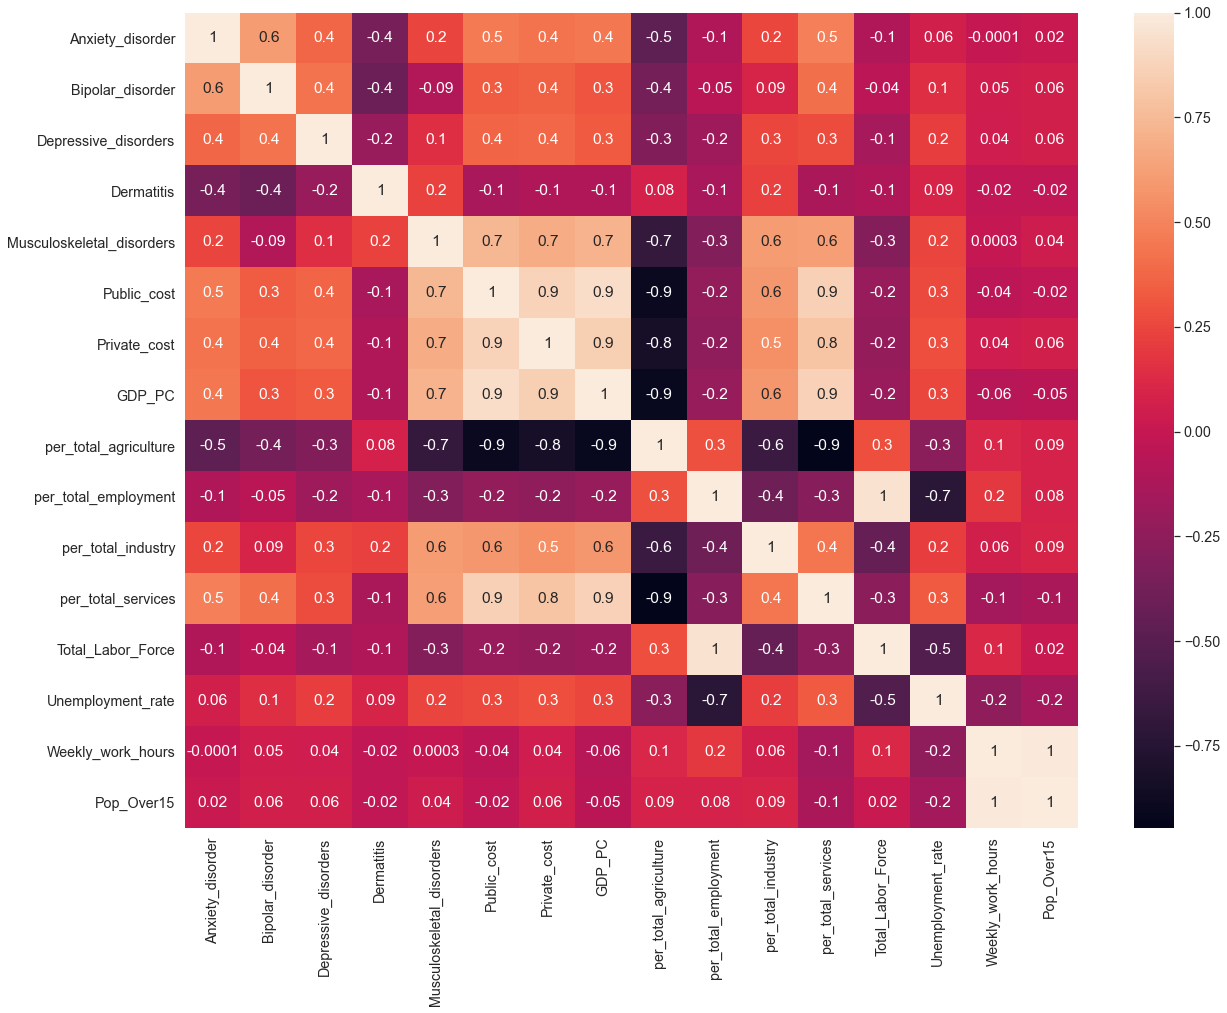

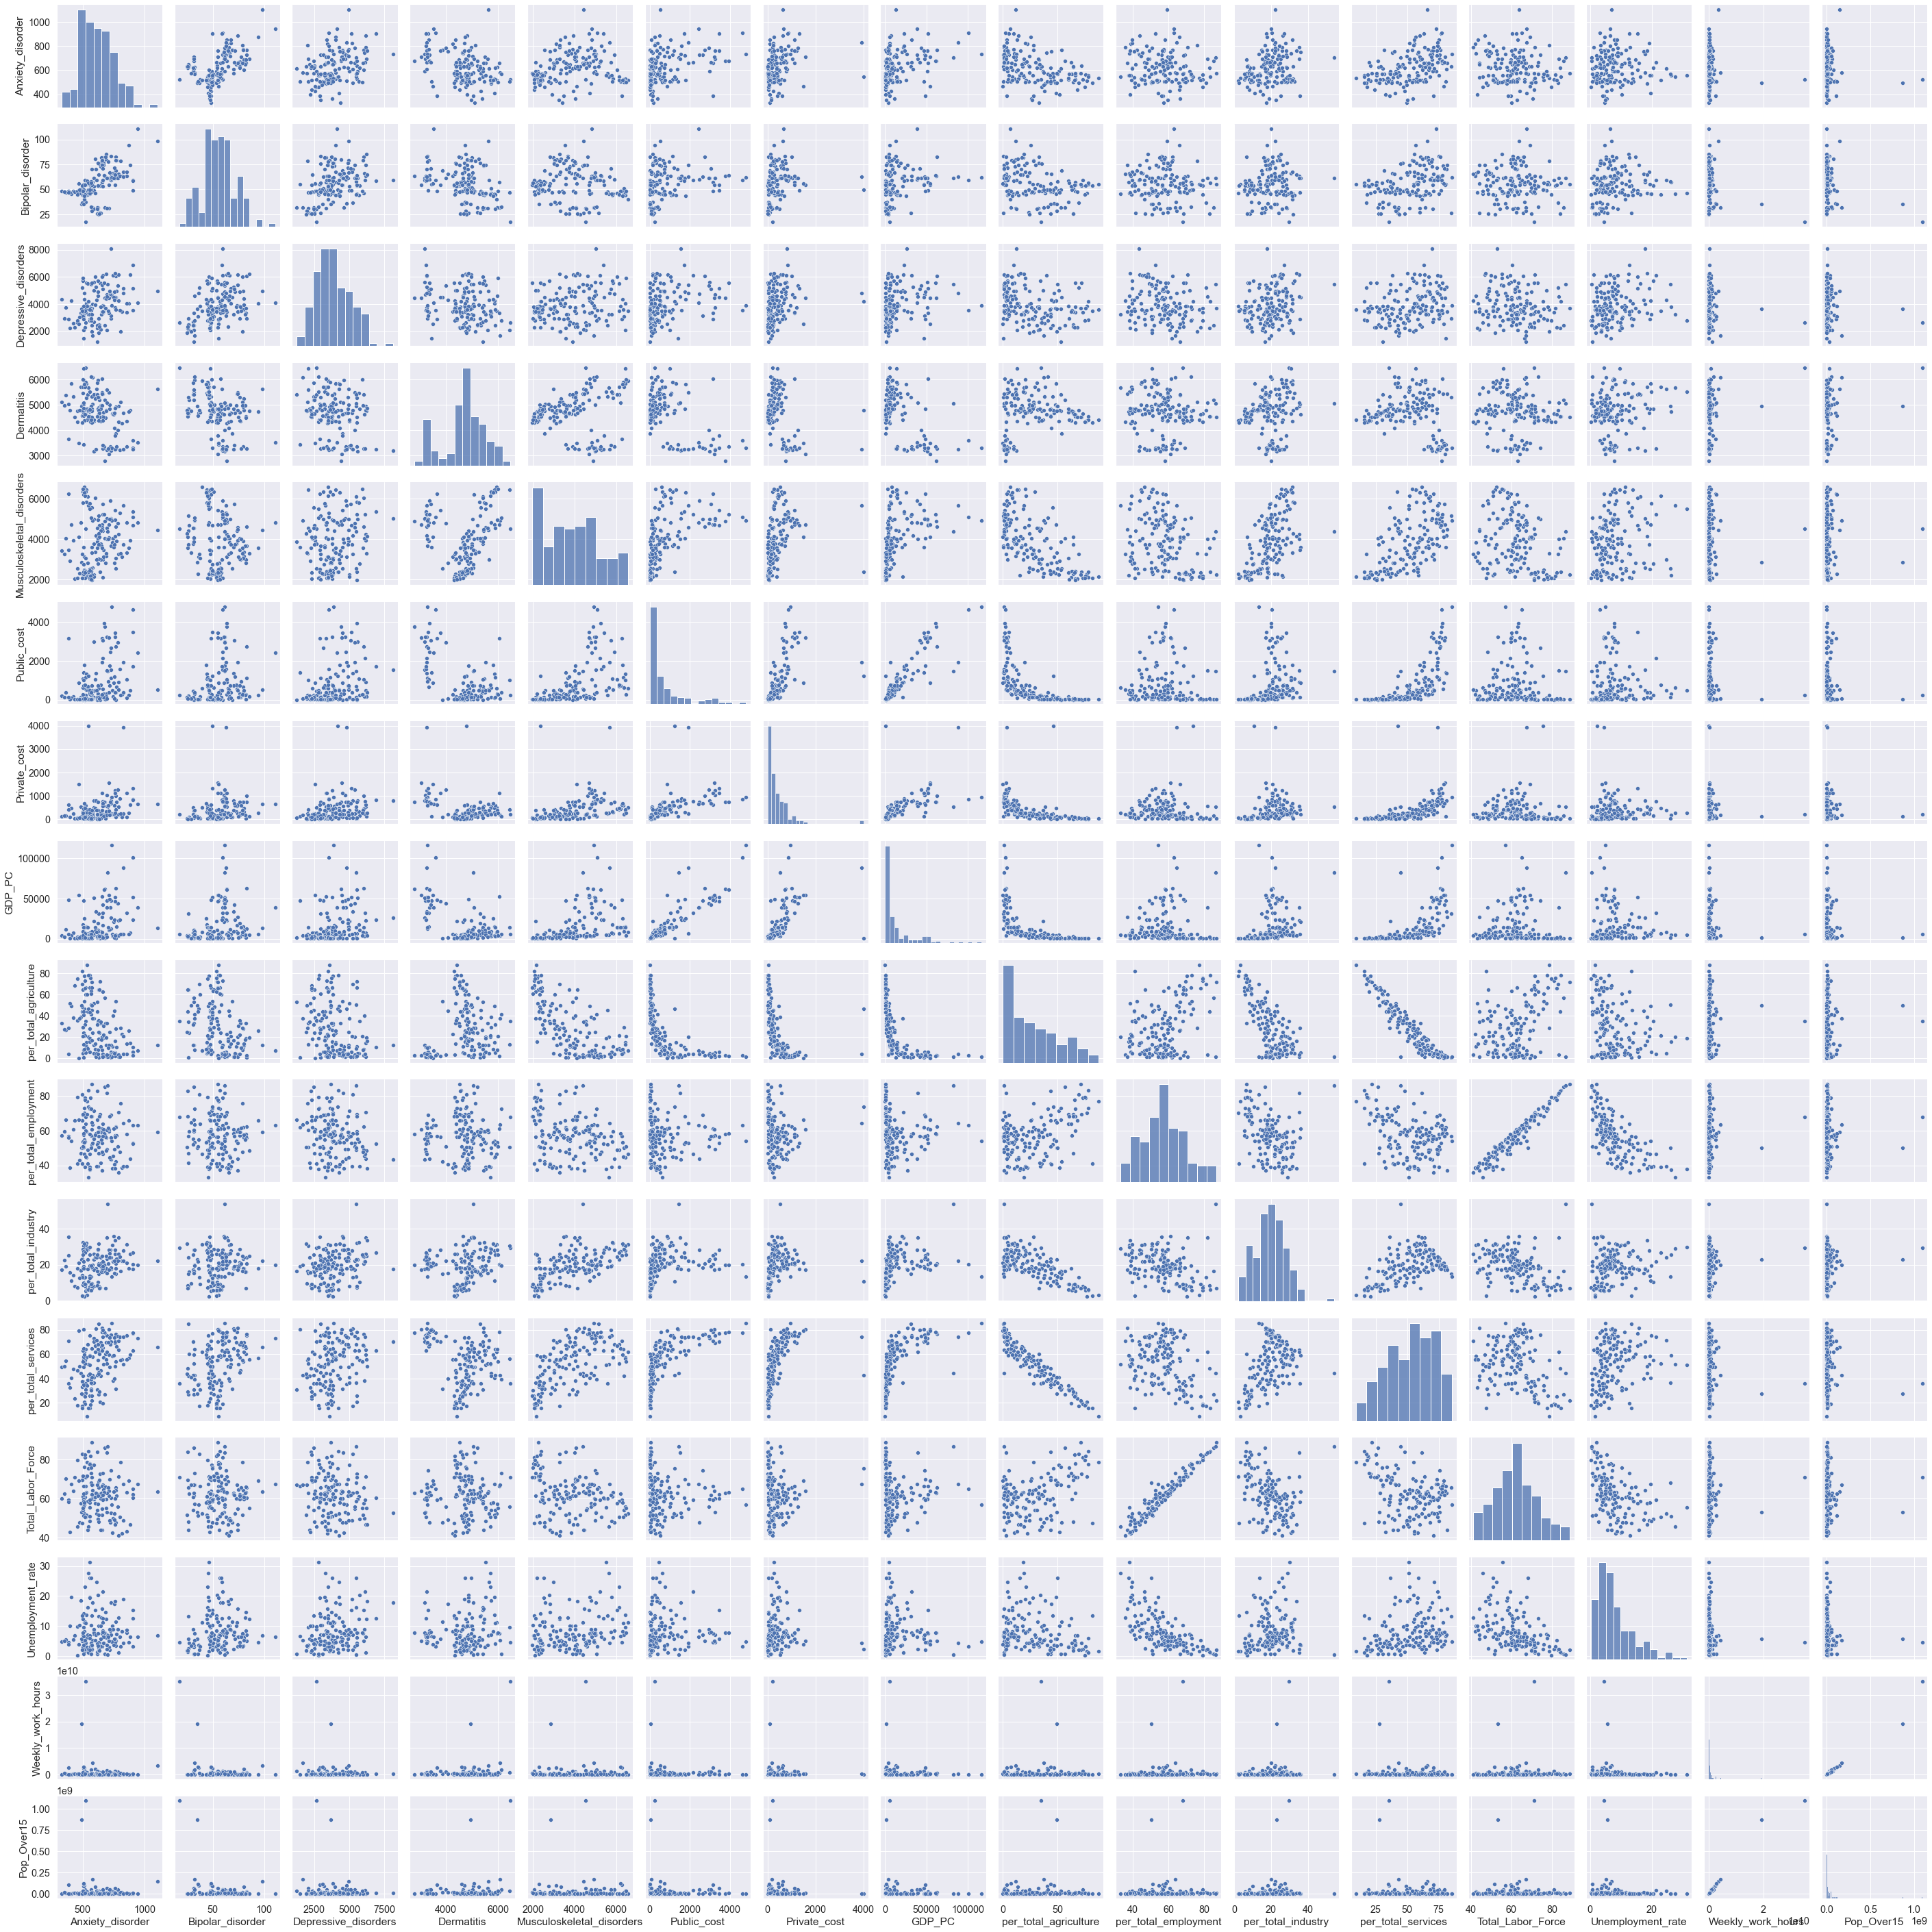

In [32]:
eval_corr(df_11,list(df_11.columns))

### Interesting correlations:
	
(.......)

#### Musc. Disorders & per_total_agriculture
* Negative correlation (-0.7)
* The more percentage the country has in agriculture, the less musc. diseases they have

* Countries with higher incidence of Musculoskeletical diseases are the ones that have:
1. smaller agriculture sector share of employees
2. Spend more in public health costs
3. Higher GDP_PC (more developped countries might mean less agriculture)

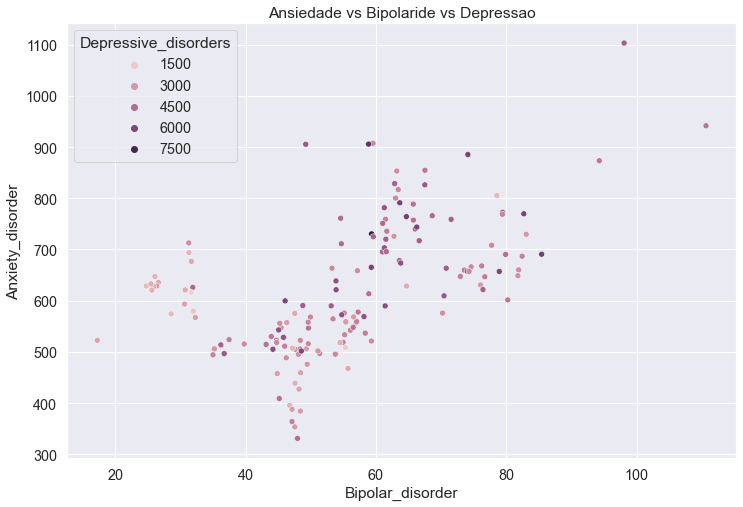

In [33]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df_11, x='Bipolar_disorder',y= 'Anxiety_disorder', hue = 'Depressive_disorders')\
.set_title('Ansiedade vs Bipolaride vs Depressao')

plt.savefig('scatter_mental.png', dpi = 200)

plt.show()

* Countries with higher incidence of Bipolar disorders are also the ones with higher incidence of Anxiety Disorders. Since these are both work related menatal diseases, we are going to group them into a single "mental disorder" category along with depression disorders (which has a positive correlation - although of smaller magnitude with the previous ones)

### Feature engineering

#### Feature Engineering steps:

1. Group all mental diseases (incidences per 100000 pp) in a single variable:
    * __mental_disorders = anxiety_disorder + bipolar_disorder + depressive_disorder__
2. Group Public_cost and Private_Cost in a single variable:
    * __total_health_cost = Private_cost + Public_cost__
4. the unemployment rate is a percentage over the total labor force. If we multiply it by the percentage of labor force over the whole population, we get the unemployment rate per Capita (__Unemp_PC__)
5. The variable __Weekly_work_hours__ is the complete amount of hours worked by employed persons on average per country. If we divide it by the number of employed persons, we get the average amount of hours worked per person (__Week_hours_PC__)

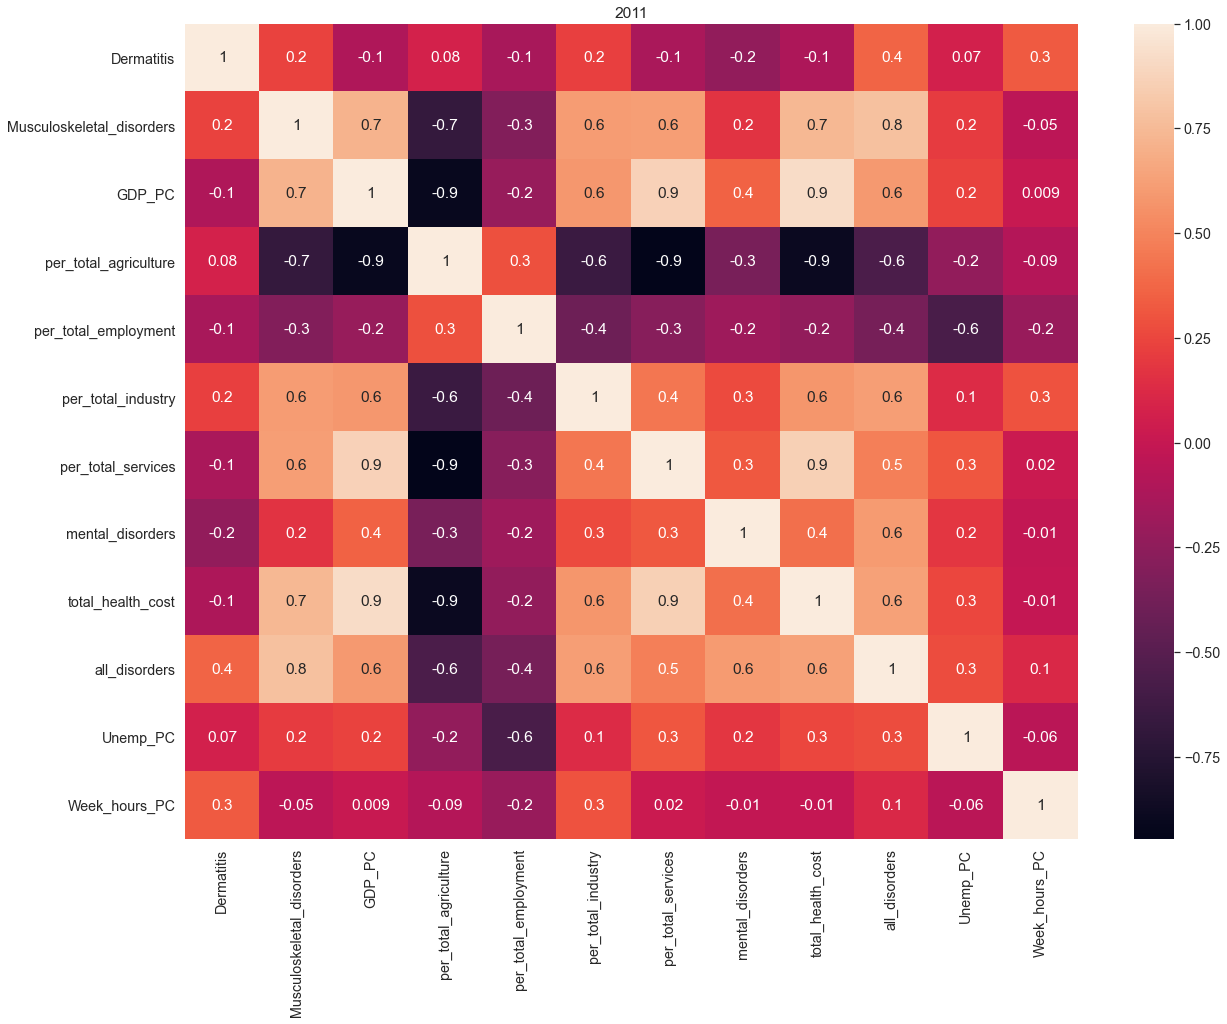

In [34]:
df_11_feat = feature_df(df_11,'2011')

In [35]:
df_11_feat.columns

Index(['Dermatitis', 'Musculoskeletal_disorders', 'GDP_PC',
       'per_total_agriculture', 'per_total_employment', 'per_total_industry',
       'per_total_services', 'mental_disorders', 'total_health_cost',
       'all_disorders', 'Unemp_PC', 'Week_hours_PC'],
      dtype='object')

### Exploration with new features

* __all_disorders__(total incidence of work related disorders) shows:
    1. Some correlation with the __GDP_PC__ (0.6) -> Countries with higher GDP tend to have more work related disorders.
    2. Some correlation with __total_health_cost__ (0.6) --> Countries with higher incidence on work related disorders tend to spend more money in health (these are also countries that tend to have higher GDP and therefore more developped)
    3. Some correlation with __per_total_industry__ (0.6) --> Countries with higher share in industry tend to have more work related disorders and less __per_total_agriculture__ (-0.6)
    
* __Week_hours_PC__ (average amount of hours worked per an employed person) shows:
    1. almost unexisting correlation with all variables except with Dermatitis and per_total_industry (but still low correlation = 0.3)
    

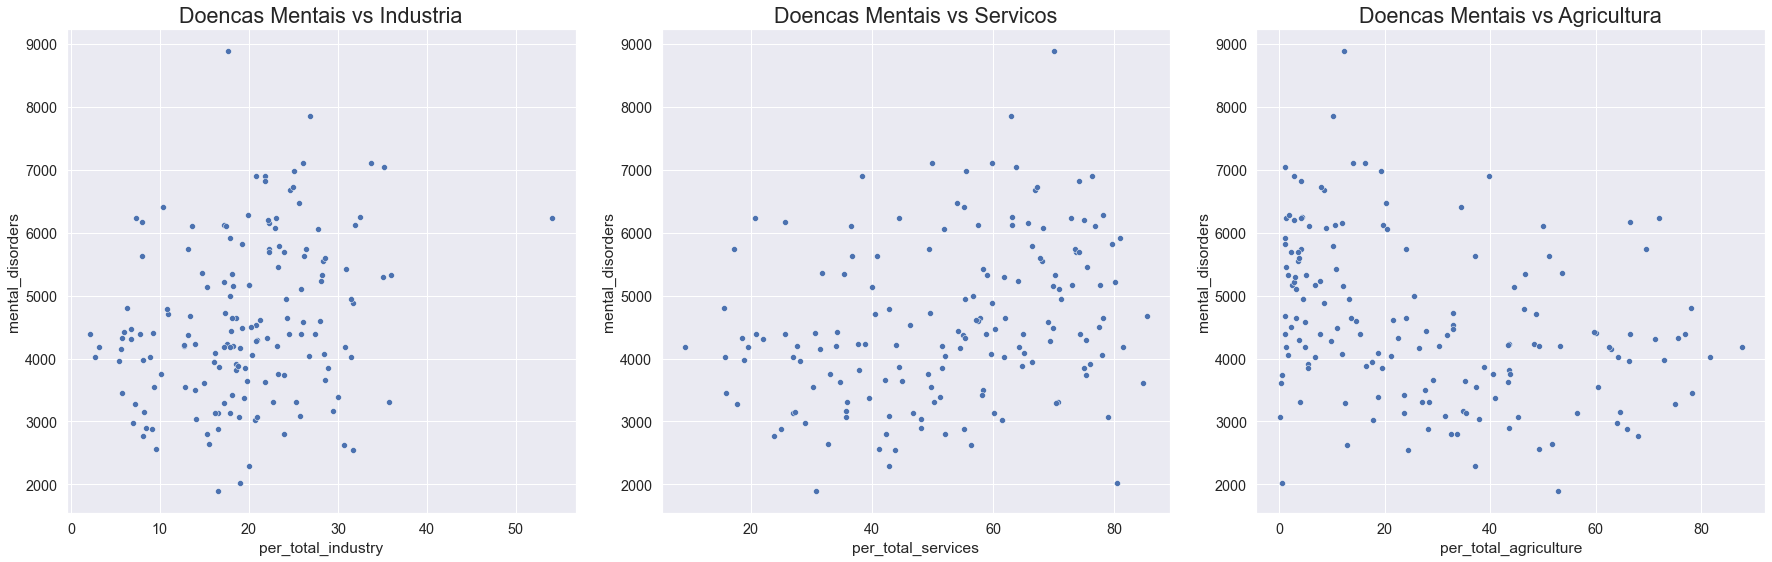

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'mental_disorders', ax=axes[0]).set_title('Doencas Mentais vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'mental_disorders', ax=axes[1]).set_title('Doencas Mentais vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'mental_disorders', ax=axes[2]).set_title('Doencas Mentais vs Agricultura')
plt.savefig('scatter_mental_sector.png', dpi = 200)
plt.show()

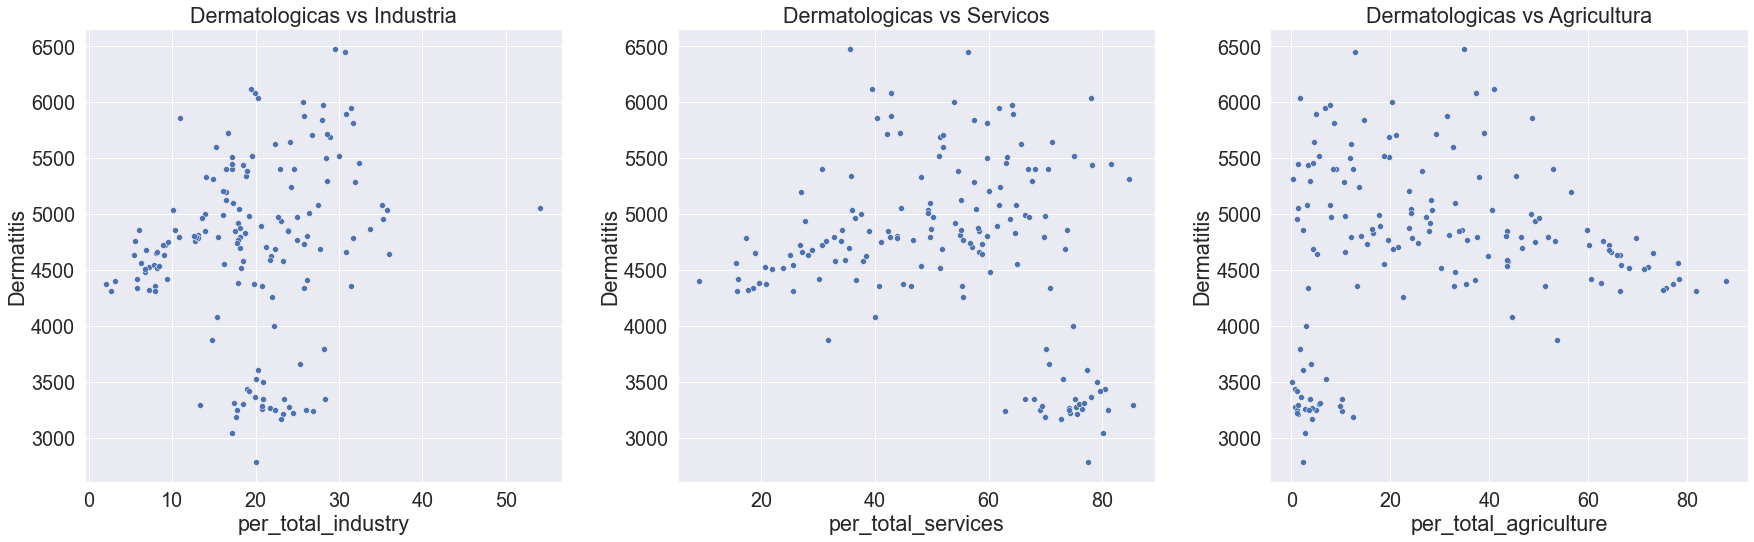

In [37]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'Dermatitis', ax=axes[0]).set_title('Dermatologicas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'Dermatitis', ax=axes[1]).set_title('Dermatologicas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'Dermatitis', ax=axes[2]).set_title('Dermatologicas vs Agricultura')
plt.savefig('scatter_derm_sector.png', dpi = 200)
plt.show()

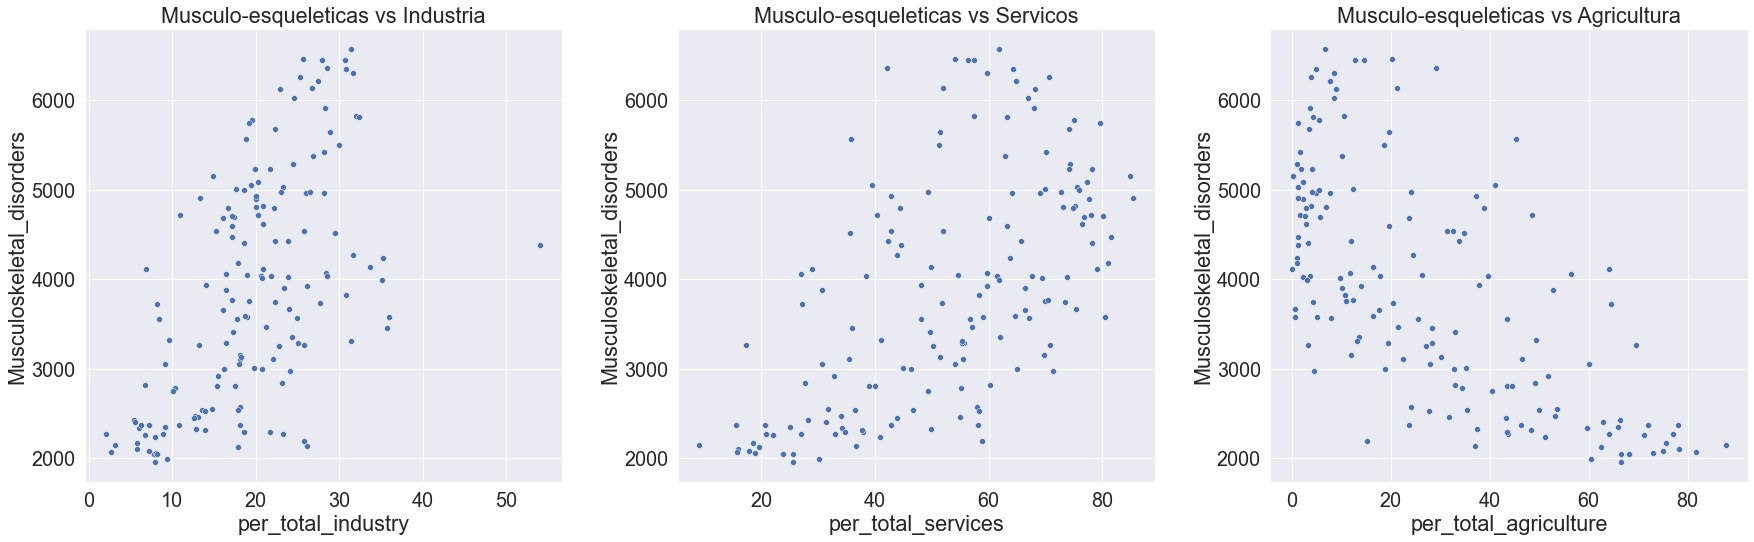

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'Musculoskeletal_disorders', ax=axes[0]).set_title('Musculo-esqueleticas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'Musculoskeletal_disorders', ax=axes[1]).set_title('Musculo-esqueleticas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'Musculoskeletal_disorders', ax=axes[2]).set_title('Musculo-esqueleticas vs Agricultura')
plt.savefig('scatter_musc_sector.png', dpi = 200)
plt.show()

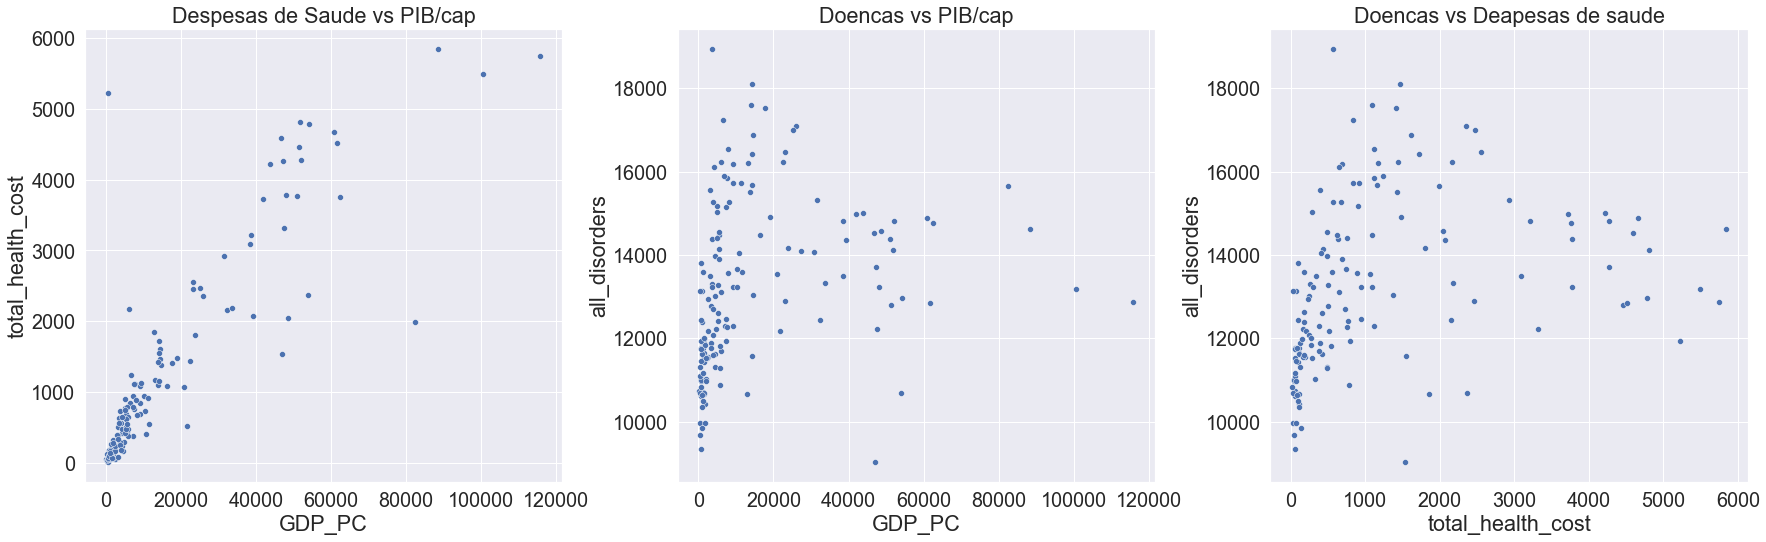

In [39]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8))
plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
sns.set(font_scale=1.8)
sns.scatterplot(data=df_11_feat, x='GDP_PC',y= 'total_health_cost', ax=axes[0]).set_title('Despesas de Saude vs PIB/cap')
sns.scatterplot(data=df_11_feat, x='GDP_PC',y= 'all_disorders', ax=axes[1]).set_title('Doencas vs PIB/cap')
sns.scatterplot(data=df_11_feat, x='total_health_cost',y= 'all_disorders', ax=axes[2]).set_title('Doencas vs Deapesas de saude')
plt.savefig('scatter_all_economics_1.png', dpi = 200)
plt.show()

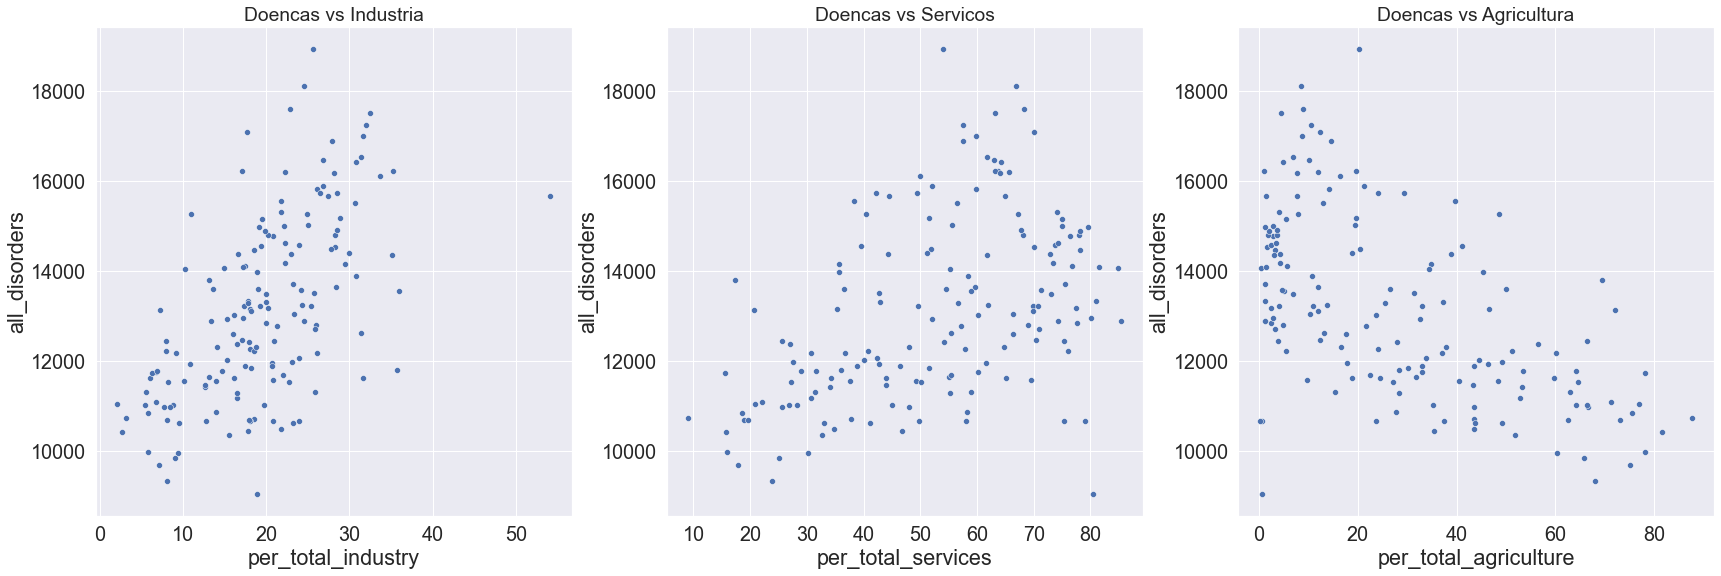

In [40]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(29, 9))
sns.set(font_scale=1.6)
sns.scatterplot(data=df_11_feat, x='per_total_industry',y= 'all_disorders', ax=axes[0]).set_title('Doencas vs Industria')
sns.scatterplot(data=df_11_feat, x='per_total_services',y= 'all_disorders', ax=axes[1]).set_title('Doencas vs Servicos')
sns.scatterplot(data=df_11_feat, x='per_total_agriculture',y= 'all_disorders', ax=axes[2]).set_title('Doencas vs Agricultura')
plt.savefig('scatter_all_sector.png', dpi = 200)
plt.show()

In [41]:
df_11_feat.describe().T

count          mean           std          min  \
Dermatitis                 157.0   4685.807259    800.362991  2788.217168   
Musculoskeletal_disorders  157.0   3874.012122   1281.833104  1961.084611   
GDP_PC                     155.0  14849.195812  21038.580011   249.577979   
per_total_agriculture      157.0     27.928917     23.622692     0.110000   
per_total_employment       157.0     57.323885     11.905351    33.090000   
per_total_industry         157.0     19.482102      8.272919     2.130000   
per_total_services         157.0     52.590892     18.614785     9.120000   
mental_disorders           157.0   4576.799247   1273.609663  1891.259135   
total_health_cost          152.0   1169.524560   1439.035438    18.263212   
all_disorders              157.0  13136.618628   2035.091456  9041.484718   
Unemp_PC                   157.0      0.047101      0.033137     0.002548   
Week_hours_PC              157.0     40.035340      4.637888    24.921116   

                                    25%           50%           75%  \
Dermatitis                  4359.897297   4765.304225   5194.156592   
Musculoskeletal_disorders   2786.073003   3764.596187   4813.597457   
GDP_PC                      1532.933408   5554.179164  17039.950587   
per_total_agriculture          5.730000     22.570000     43.720001   
per_total_employment          49.279999     57.200001     64.489998   
per_total_industry            14.080000     19.250000     24.959999   
per_total_services            37.840000     55.240002     68.029999   
mental_disorders            3661.111153   4386.985791   5455.438481   
total_health_cost            147.008910    562.994869   1494.632038   
all_disorders              11568.542317  12938.905149  14551.929738   
Unemp_PC                       0.024947      0.039019      0.055988   
Week_hours_PC                 37.129990     39.805248     42.665801   

                                     max  
Dermatitis                   6474.560792  
Musculoskeletal_disorders    6569.524981  
GDP_PC                     115761.507705  
per_total_agriculture          87.750000  
per_total_employment           86.940002  
per_total_industry             54.110001  
per_total_services             85.410004  
mental_disorders             8895.963290  
total_health_cost            5841.042480  
all_disorders               18936.444518  
Unemp_PC                        0.177124  
Week_hours_PC                  52.461410

### Missing Values
(Using the Gradient Boosting)

In [42]:
pd.DataFrame({'#NA: 2011': df_11_feat.isna().sum()})

#NA: 2011
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             2
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  5
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      0

In [43]:
df_11_feat.loc[df_11_feat.isnull().any(axis=1)]

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Guam                  5318.615132                5149.008697  30859.404353   
Montenegro            5523.438917                5773.516912   7329.026063   
Puerto Rico           5449.261183                4469.123640  27278.883050   
Somalia               4316.467890                2070.611927           NaN   
South Sudan           4389.049946                2119.947286   1516.403915   
Syrian Arab Republic  4359.897297                3309.178846           NaN   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Guam                               0.310000             56.990002   
Montenegro                         5.470000             38.910000   
Puerto Rico                        1.320000             37.009998   
Somalia                           81.680000             41.160000   
South Sudan                       62.529999             63.990002   
Syrian Arab Republic              13.230000             39.509998   

                      per_total_industry  per_total_services  \
location_name                                                  
Guam                           14.920000           84.769997   
Montenegro                     19.549999           74.980003   
Puerto Rico                    17.200001           81.480003   
Somalia                         2.640000           15.680000   
South Sudan                    17.889999           19.580000   
Syrian Arab Republic           31.430000           55.340000   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Guam                       3603.135372                NaN   14070.759201   
Montenegro                 3854.116690                NaN   15151.072519   
Puerto Rico                4177.754035                NaN   14096.138857   
Somalia                    4023.196109                NaN   10410.275926   
South Sudan                4181.216614                NaN   10690.213845   
Syrian Arab Republic       4953.190408          180.40152   12622.266550   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Guam                  0.087434      43.100818  
Montenegro            0.095281      40.858922  
Puerto Rico           0.068939      39.297917  
Somalia               0.063582      36.247212  
South Sudan           0.092012      36.168959  
Syrian Arab Republic  0.037178      42.539269

In [44]:
df_11_gb = (
    df_11_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
)

In [45]:
df_11_gb.loc[df_11_feat.isnull().any(axis=1)]
# Gradient Boosting imputed a negative total_health_cost value for Somalia, which should be corrected.
#To simplify the analysis, this line will be removed, along with outliers

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Guam                  5318.615132                5149.008697  30859.404353   
Montenegro            5523.438917                5773.516912   7329.026063   
Puerto Rico           5449.261183                4469.123640  27278.883050   
Somalia               4316.467890                2070.611927    689.672649   
South Sudan           4389.049946                2119.947286   1516.403915   
Syrian Arab Republic  4359.897297                3309.178846   3675.536459   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Guam                               0.310000             56.990002   
Montenegro                         5.470000             38.910000   
Puerto Rico                        1.320000             37.009998   
Somalia                           81.680000             41.160000   
South Sudan                       62.529999             63.990002   
Syrian Arab Republic              13.230000             39.509998   

                      per_total_industry  per_total_services  \
location_name                                                  
Guam                           14.920000           84.769997   
Montenegro                     19.549999           74.980003   
Puerto Rico                    17.200001           81.480003   
Somalia                         2.640000           15.680000   
South Sudan                    17.889999           19.580000   
Syrian Arab Republic           31.430000           55.340000   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Guam                       3603.135372        2556.532563   14070.759201   
Montenegro                 3854.116690        1741.460354   15151.072519   
Puerto Rico                4177.754035        1292.237917   14096.138857   
Somalia                    4023.196109         -93.331515   10410.275926   
South Sudan                4181.216614          19.787779   10690.213845   
Syrian Arab Republic       4953.190408         180.401520   12622.266550   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Guam                  0.087434      43.100818  
Montenegro            0.095281      40.858922  
Puerto Rico           0.068939      39.297917  
Somalia               0.063582      36.247212  
South Sudan           0.092012      36.168959  
Syrian Arab Republic  0.037178      42.539269

### 1. Remove Outliers

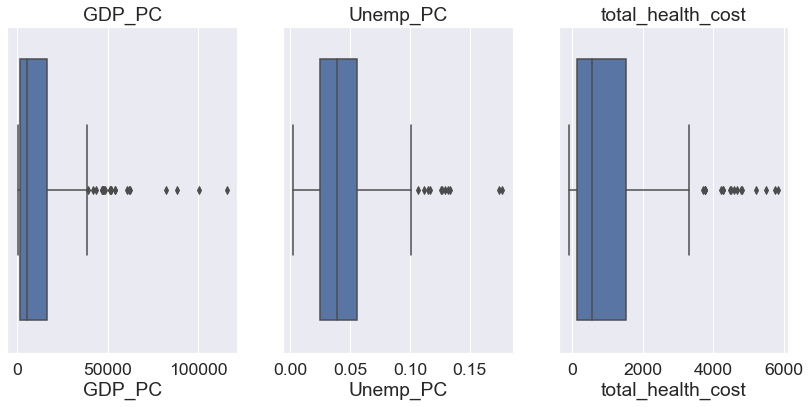

skew      kurt
Dermatitis                -0.361964 -0.284530
Musculoskeletal_disorders  0.307942 -0.931164
GDP_PC                     2.238577  5.521022
per_total_agriculture      0.653955 -0.703915
per_total_employment       0.285899 -0.274244
per_total_industry         0.329752  0.970704
per_total_services        -0.306074 -0.893237
mental_disorders           0.466218 -0.003642
total_health_cost          1.623812  1.804404
all_disorders              0.428805 -0.443135
Unemp_PC                   1.440331  2.288144
Week_hours_PC             -0.197083  1.085889

In [46]:
eval_outliers(df_11_gb,['GDP_PC','Unemp_PC','total_health_cost'])
#In total_health_cost, the observations after Q3 are not much separated from each other, so we will not remove them
#In both GDP_PC and Unemp_PC, we can visually observe a big separation between the extreme points and the remaining

In [47]:
#check removal data: outliers & errors
pd.concat([df_11_gb.loc[df_11_gb.Unemp_PC > 0.15],df_11_gb.loc[df_11_gb.GDP_PC > 75000],df_11_gb.loc[df_11_gb.total_health_cost < 0]])

Dermatitis  Musculoskeletal_disorders         GDP_PC  \
location_name                                                            
Lesotho          4963.937157                2533.258411    1308.690069   
North Macedonia  5524.033277                5497.728910    5063.786986   
Luxembourg       3291.846818                4910.542012  115761.507705   
Norway           3604.407771                5091.140820  100600.562408   
Qatar            5052.915012                4378.810274   82409.577333   
Switzerland      3253.039580                5676.299312   88415.628032   
Somalia          4316.467890                2070.611927     689.672649   

                 per_total_agriculture  per_total_employment  \
location_name                                                  
Lesotho                      49.959999             50.310001   
North Macedonia              18.740000             38.060001   
Luxembourg                    1.230000             54.070000   
Norway                        2.370000             63.110001   
Qatar                         1.360000             86.330002   
Switzerland                   3.510000             64.489998   
Somalia                      81.680000             41.160000   

                 per_total_industry  per_total_services  mental_disorders  \
location_name                                                               
Lesotho                   13.570000           36.470001       6102.558954   
North Macedonia           30.000000           51.259998       3383.652053   
Luxembourg                13.360000           85.410004       4678.384870   
Norway                    20.250000           77.379997       4493.084254   
Qatar                     54.110001           44.540001       6230.564578   
Switzerland               22.280001           74.209999       5698.514422   
Somalia                    2.640000           15.680000       4023.196109   

                 total_health_cost  all_disorders  Unemp_PC  Week_hours_PC  
location_name                                                               
Lesotho                 174.807991   13599.754522  0.177124      39.688237  
North Macedonia         748.700623   14405.414241  0.174065      41.482930  
Luxembourg             5746.539917   12880.773699  0.027856      38.060179  
Norway                 5492.077148   13188.632845  0.020994      34.589620  
Qatar                  1984.346008   15662.289864  0.004862      50.033183  
Switzerland            5841.042480   14627.853314  0.029682      37.122342  
Somalia                 -93.331515   10410.275926  0.063582      36.247212

In [48]:
index_2_remove = pd.concat([df_11_gb.loc[df_11_gb.Unemp_PC > 0.15],df_11_gb.loc[df_11_gb.GDP_PC > 75000],df_11_gb.loc[df_11_gb.total_health_cost < 0]]).index
df_11_no = df_11_gb.drop(index = list(index_2_remove))

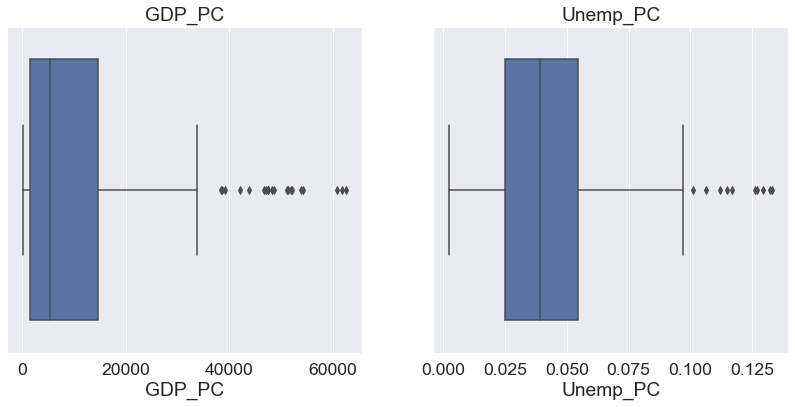

skew      kurt
Dermatitis                -0.375481 -0.181972
Musculoskeletal_disorders  0.359456 -0.857062
GDP_PC                     1.606867  1.419607
per_total_agriculture      0.630033 -0.727349
per_total_employment       0.251156 -0.301841
per_total_industry        -0.074887 -0.578726
per_total_services        -0.322071 -0.894565
mental_disorders           0.494833  0.041753
total_health_cost          1.577308  1.604871
all_disorders              0.464277 -0.437205
Unemp_PC                   1.096926  0.674843
Week_hours_PC             -0.272089  1.142820

In [49]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_11_no,['GDP_PC','Unemp_PC'])

## Cluster Analysis

### Correlation check

### Scenario 1: __For 2011__, considering the following features:

1. per_total_employment -> removed (leave only one labor overall indicator)
2. __Unemp_PC__
3. __Week_hours_PC__
4. GDP_PC (__high corr__) -> removed
5. total_health_cost (__high corr__) -> removed
6. __All_disorders__
7. __per_total_services__
8. per_total_industry -> remove (medium high correlation to services)


--> __Now we try per_total_employment, all_disorders, Week_hours_PC, total_health_cost__:

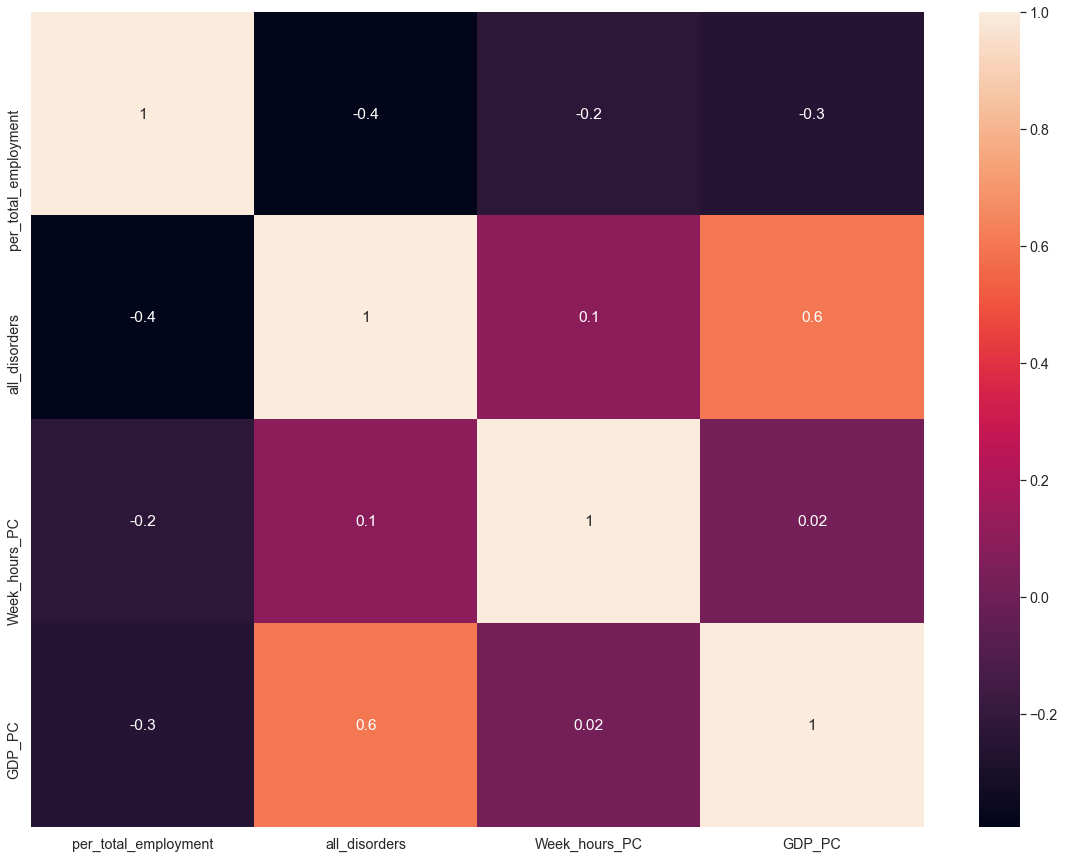

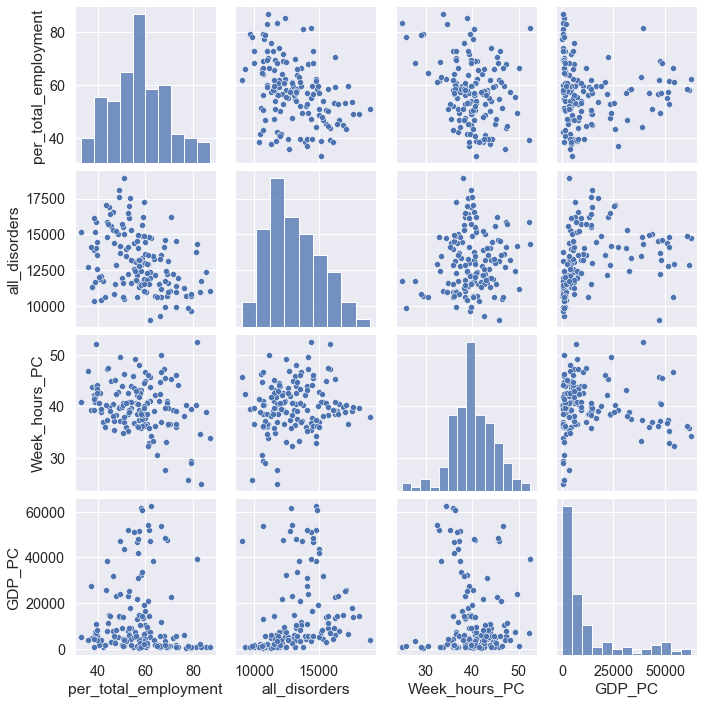

In [50]:
cols_eval = ['per_total_employment','all_disorders', 'Week_hours_PC','GDP_PC']

#cols_eval = ['per_total_services','all_disorders', 'Unemp_PC', 'Week_hours_PC']
             
eval_corr(df_11_no,cols_eval)

In [51]:
df_sc_1 = df_11_no[cols_eval]

### Evaluate normality of distributions

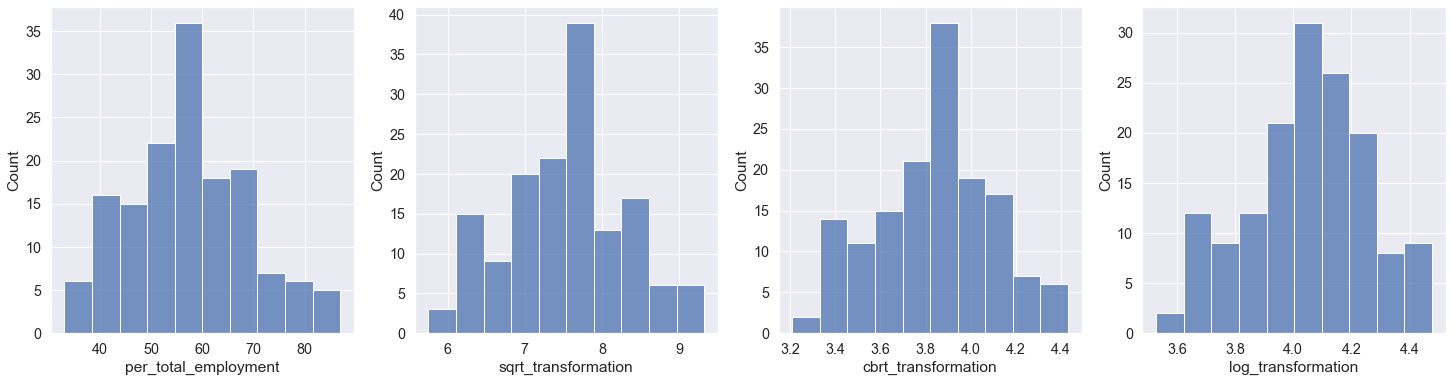

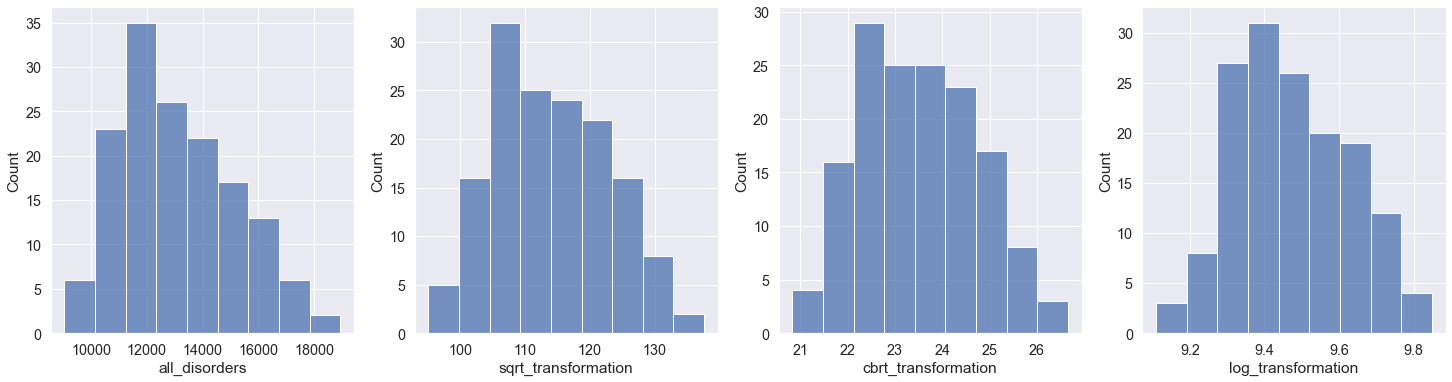

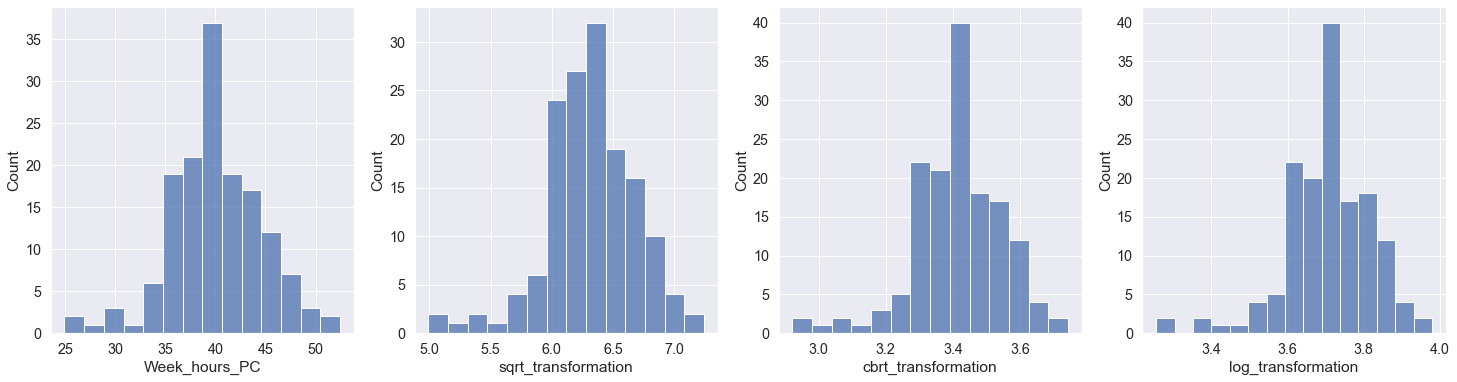

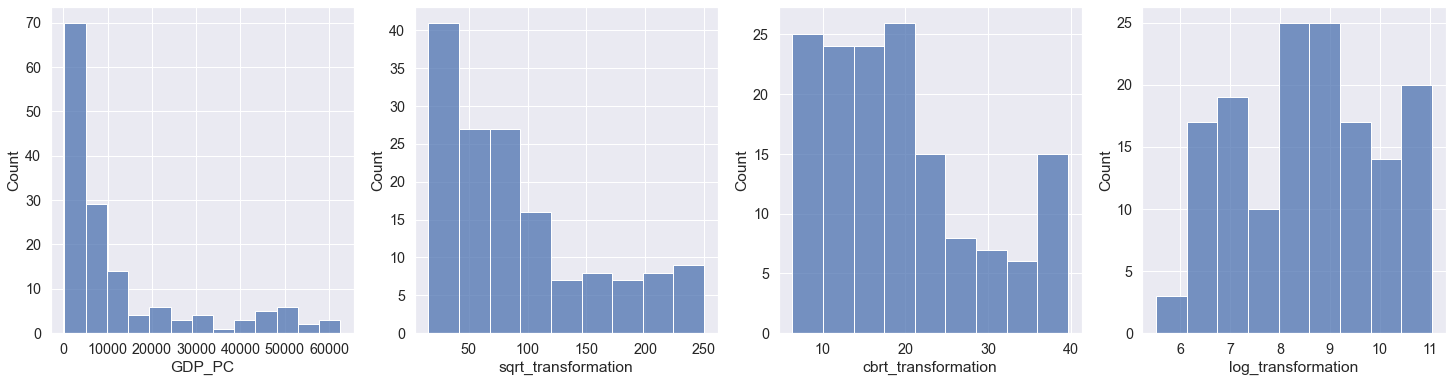

In [52]:
pt_evaluation(df_sc_1, 'per_total_employment')
pt_evaluation(df_sc_1, 'all_disorders')
pt_evaluation(df_sc_1, 'Week_hours_PC')
pt_evaluation(df_sc_1, 'GDP_PC')


In [53]:
df_sc1_t = df_sc_1[[]]
df_sc1_t = df_sc1_t.assign(per_total_employment_cb = np.cbrt(df_sc_1['per_total_employment']))
df_sc1_t = df_sc1_t.assign(all_disorders_cb = np.cbrt(df_sc_1['all_disorders']))
df_sc1_t = df_sc1_t.assign(Week_hours_PC_norm = (df_sc_1['Week_hours_PC']))
df_sc1_t = df_sc1_t.assign(GDP_PC_norm = np.log(df_sc_1['GDP_PC']+1))



<AxesSubplot:>

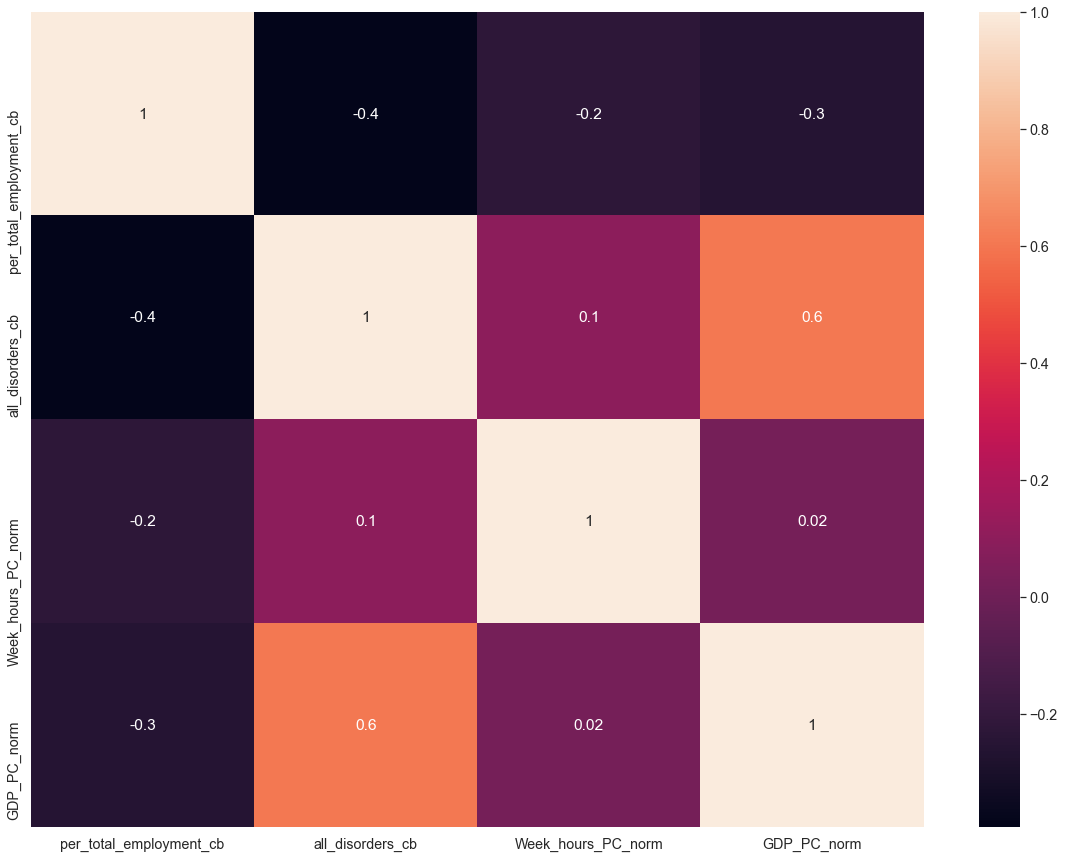

In [54]:
sns.set(font_scale=1.3)
df_corr = df_sc1_t.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

In [55]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc1_t), columns=df_sc1_t.columns)

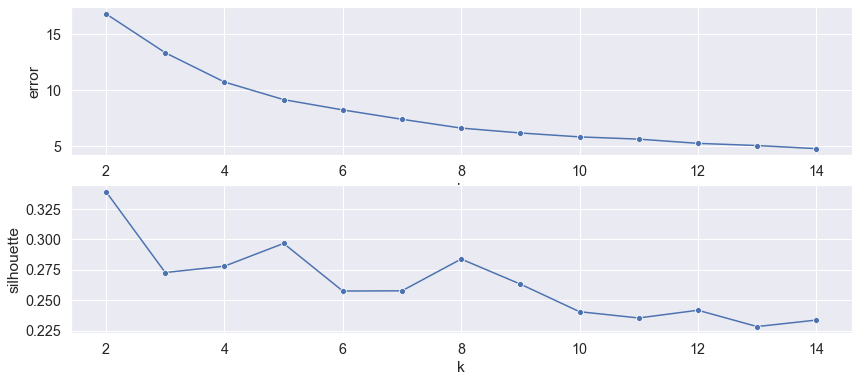

In [56]:
evaluate_number_clusters(minmax_sc1,15)

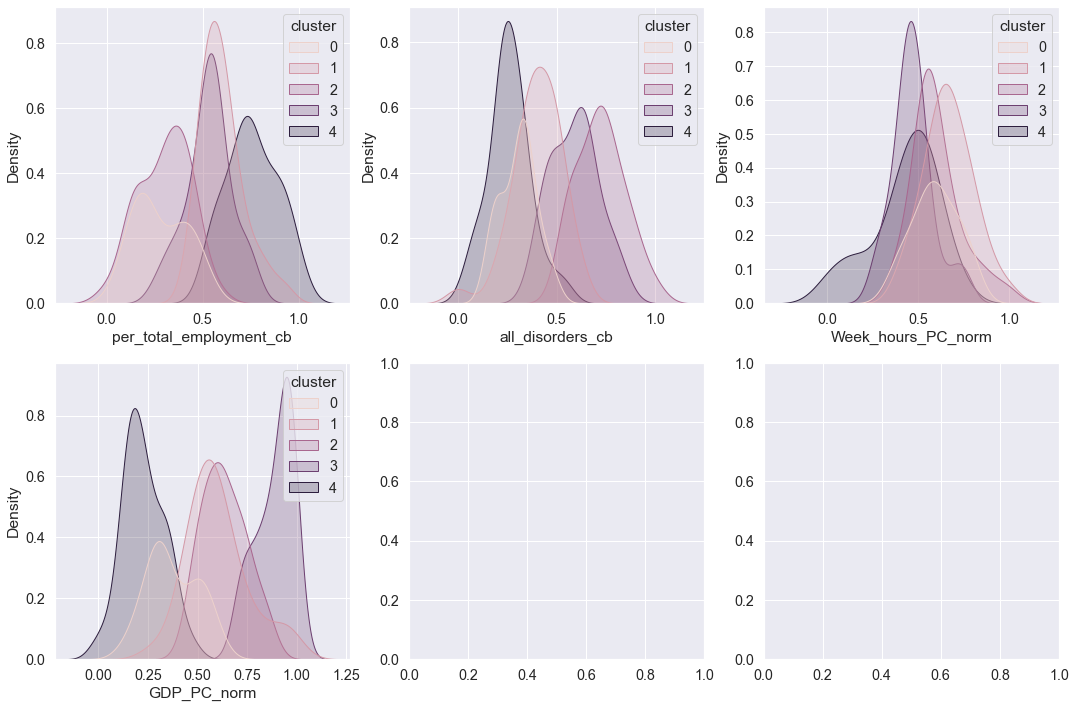

In [57]:
df_cluster_11, kmeans = evaluate_cluster(minmax_sc1, df_sc_1, 5)

In [58]:
agreg_clusters(df_cluster_11)

labels per_total_employment all_disorders Week_hours_PC    GDP_PC
        count                 mean          mean          mean      mean
labels                                                                  
0          20                45.05      11563.55         41.23   2459.20
1          35                61.40      12458.84         43.27  10333.63
2          31                45.97      15731.95         41.46   9952.19
3          31                57.63      14318.15         37.86  37373.85
4          33                70.93      11175.47         36.68   1023.42

### Visualize graphically the differences between clusters

In [59]:
df_aggreg_11 = agreg_clusters(df_cluster_11)
df_aggreg_11 = pd.DataFrame({
    'taxa de emprego [%]': df_aggreg_11[('per_total_employment','mean')],
    'doencas [/100k habs]':df_aggreg_11[('all_disorders','mean')],
    'PIB [$/cap]': df_aggreg_11[('GDP_PC','mean')],
    'horas de trabalho [/sem]': df_aggreg_11[('Week_hours_PC','mean')]
    })
df_aggreg_11['cluster'] = ['0','1','2','3','4']

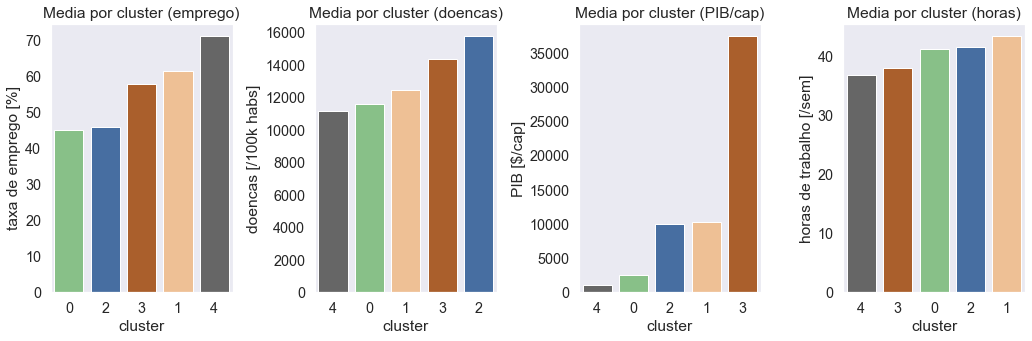

In [78]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
plt.tight_layout(pad=2, w_pad=2.5, h_pad=1.0)
palette ={"0": '#7fc97f', "1": "#fdc086", "2": "#386cb0", '3':'#bf5b17', '4':'#666666'}
sns.barplot(x="cluster", y="taxa de emprego [%]",order =['0','2','3','1','4'], data=df_aggreg_11,ax = axes[0],palette = palette).set_title('Media por cluster (emprego)')
sns.barplot(x="cluster", y="doencas [/100k habs]",order =['4','0','1','3','2'], data=df_aggreg_11,ax = axes[1],palette = palette).set_title('Media por cluster (doencas)')
sns.barplot(x="cluster", y="PIB [$/cap]",order =['4','0','2','1','3'], data=df_aggreg_11,ax = axes[2],palette = palette).set_title('Media por cluster (PIB/cap)')
sns.barplot(x="cluster", y="horas de trabalho [/sem]",order =['4','3','0','2','1'], data=df_aggreg_11,ax = axes[3],palette = palette).set_title('Media por cluster (horas)')
for i in range(0,4):
    axes[i].grid(False)

plt.savefig('cluster_eval.png', dpi = 500)
plt.show()

### Check distribution of other variables for the 5 clusters in 2011
1. Which sectors characterize each cluster

In [140]:
df_others = pd.concat([df_11_no[['per_total_agriculture','per_total_industry','per_total_services',\
                                 'Musculoskeletal_disorders','Dermatitis','mental_disorders']],\
                       df_cluster_11['labels']], axis=1)

df_others.rename(columns={'per_total_agriculture':'Agricultura [%]','per_total_industry':'Industria[%]',\
                      'per_total_services':'Servicos [%]','Musculoskeletal_disorders':\
                      'Doencas Musculo-esqueleticas [/100k habs]','Dermatitis':'Doencas dermatologicas [/100k habs]'\
                  ,'mental_disorders':'Disturbios mentais [/100k habs]'}, inplace=True)
    
#add color code through palette:
palette ={0: '#7fc97f', 1: "#fdc086", 2: "#386cb0", 3:'#bf5b17', 4:'#666666'}

df_others['Cluster_Color'] = df_others['labels'].map(palette)

df_others_agg = df_others.groupby('labels').agg('mean').round(2)

1. Which diseases characterize each cluster?
2. Which sectors most characterize each cluster?

In [90]:
import math

In [149]:
def plot_clusters_correlations(df,file_name, x="", dimensions="", color="", shape = None):
    """
        plot set of boxplot rows and cols based on input 
    """
    n_cols = 2
    n_rows = math.ceil(len(dimensions) / n_cols)
    
    palette ={0: '#7fc97f', 1: "#fdc086", 2: "#386cb0", 3:'#bf5b17', 4:'#666666'}
    
    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(18, n_rows * 6))
    plt.tight_layout(pad=2, w_pad=3, h_pad=1.0)
    
    
    row = 0
    col = 0
    for dim in dimensions:
        
        sns.boxplot(ax=axes[row, col], x = x, y=dim, data = df,palette = palette).set(xlabel='cluster')

        if col % 2:
            row += 1
            col = 0
        else:
            col += 1
        
    for ax in fig.axes:
        ax.tick_params(labelrotation=0)
   
    file_name = file_name + '.png'
    plt.savefig(file_name, dpi = 500)
    
    plt.show()
    
    return fig

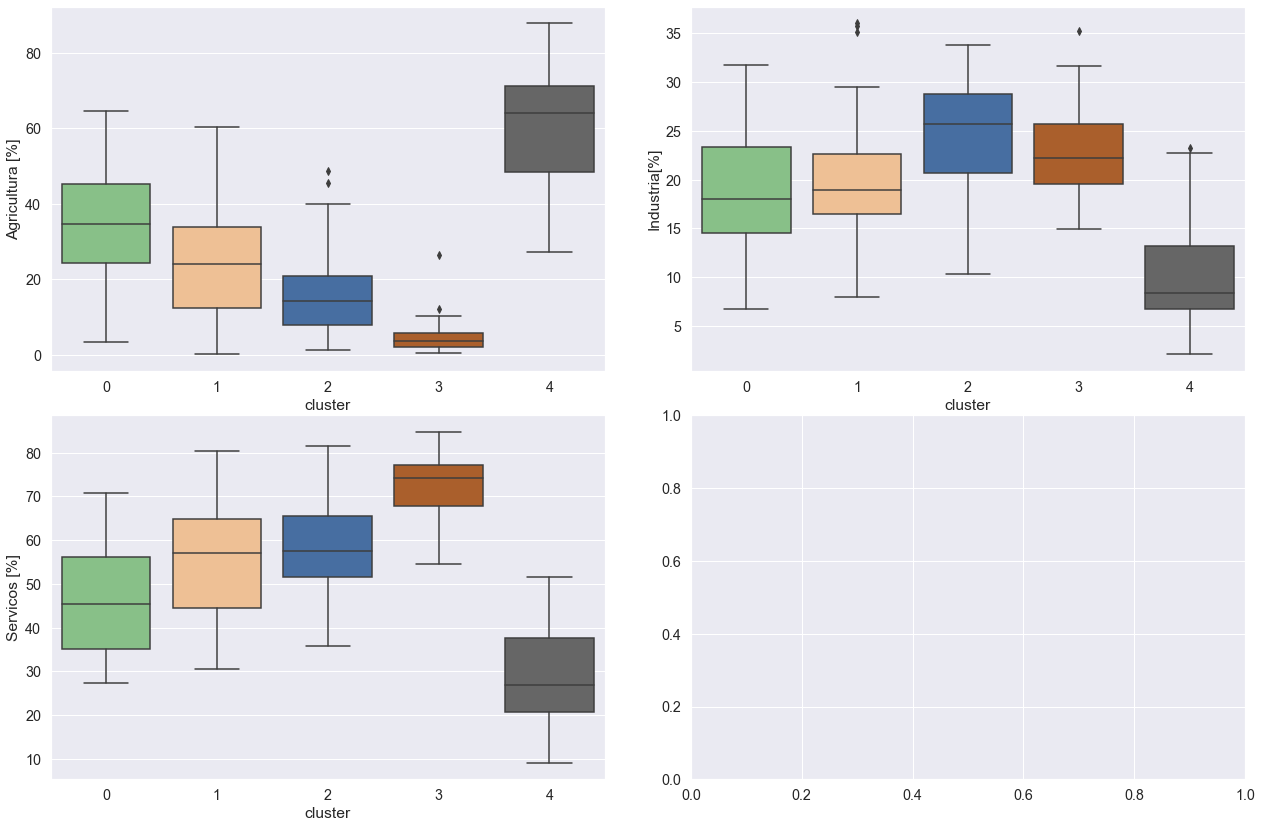

In [150]:
_fig = plot_clusters_correlations(df_others,'sectors','labels',[
                                        'Agricultura [%]', 
                                        'Industria[%]',
                                        'Servicos [%]',
                                       ])

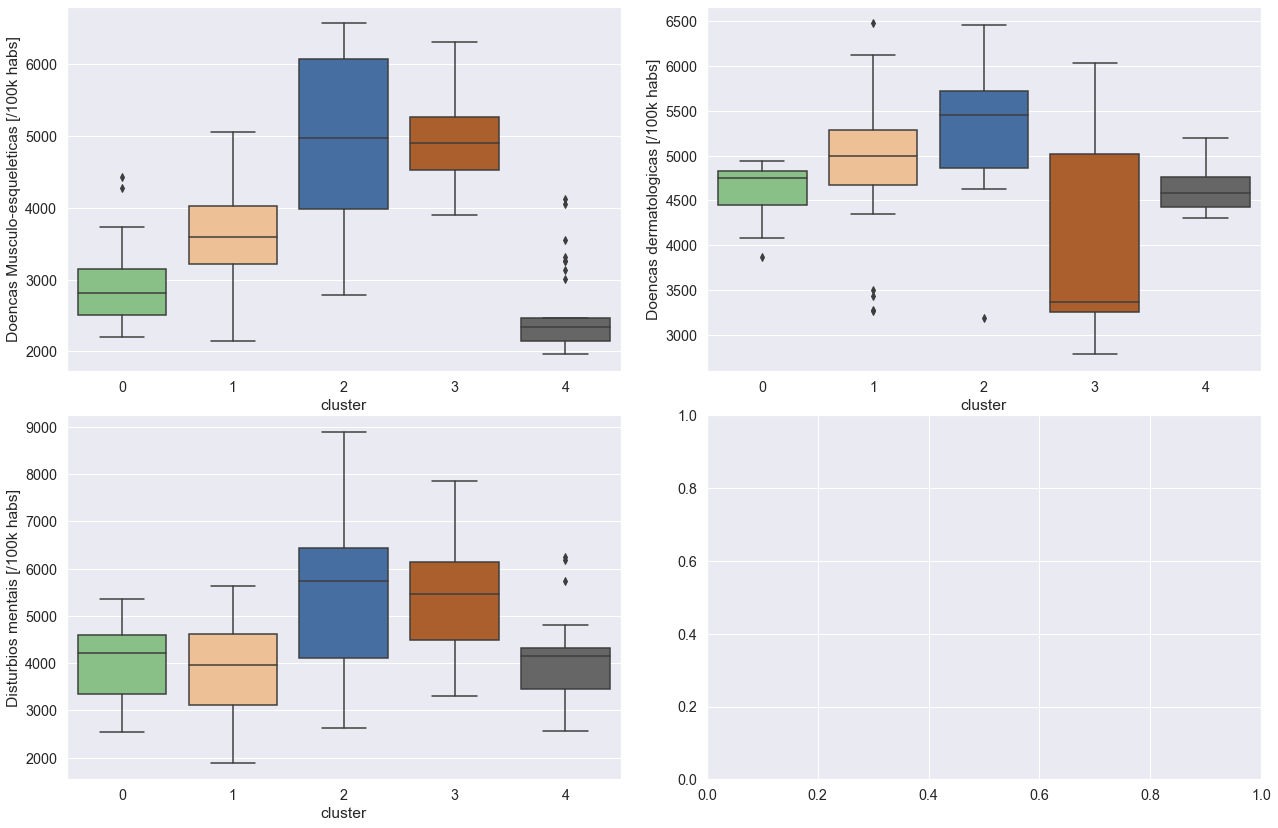

In [151]:
_fig = plot_clusters_correlations(df_others,'diseases','labels',[
                                        'Doencas Musculo-esqueleticas [/100k habs]', 
                                        'Doencas dermatologicas [/100k habs]',
                                        'Disturbios mentais [/100k habs]',
                                       ])

### Build df for 2017 to compare to 2011

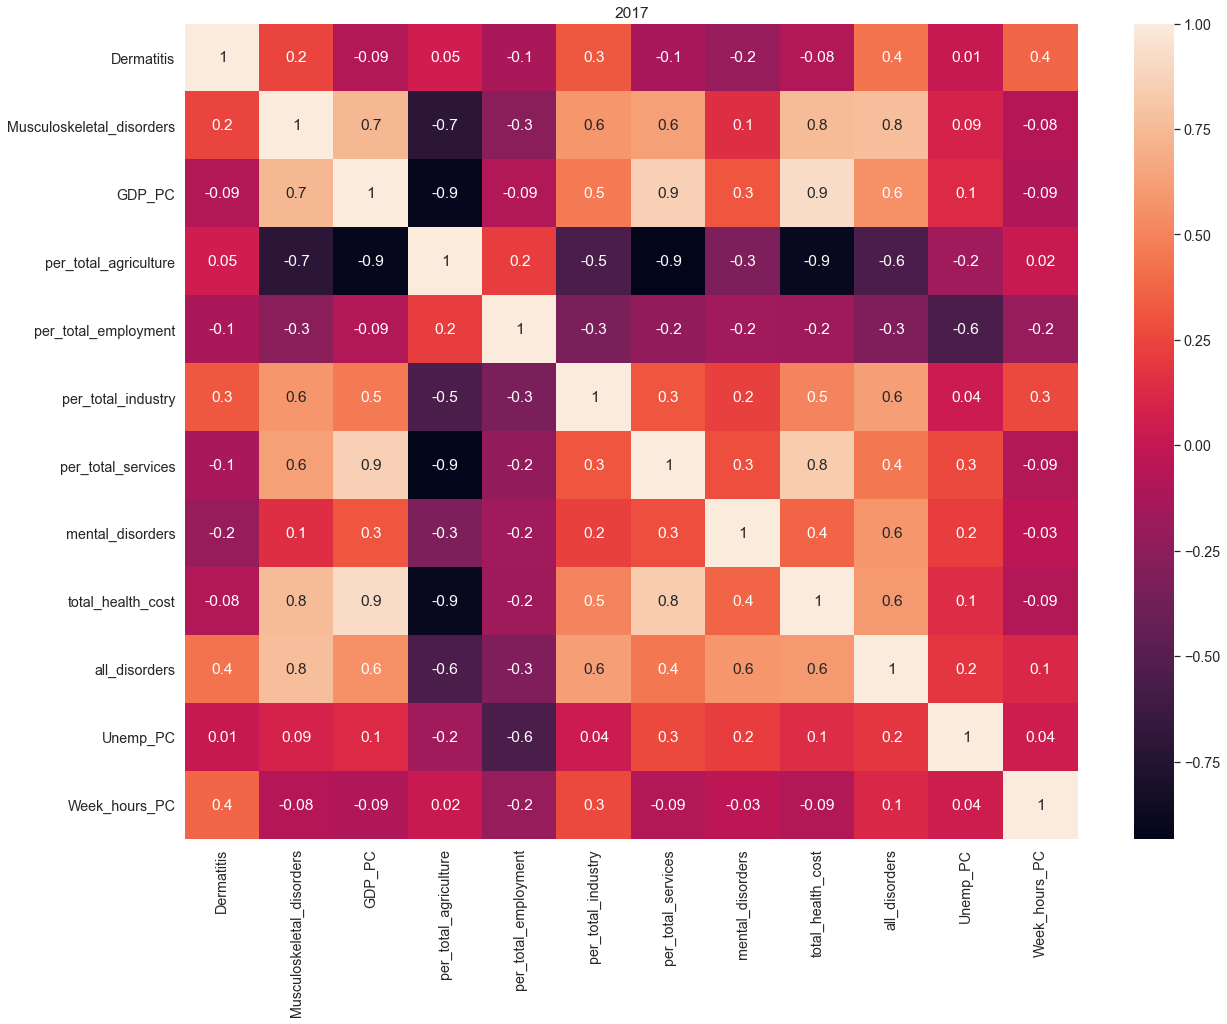

In [63]:
df_17 = merge2complete('2017') ## get full unprocessed df for 2011
df_17_feat = feature_df(df_17,'2017') ## feature eng. df

In [64]:
pd.DataFrame({'#NA: 2017': df_17_feat.isna().sum()})

#NA: 2017
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             3
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  6
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      1

In [65]:
df_17_gb = (
    df_17_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Week_hours_PC')
) ## Fill missing values using GB again

In [66]:
#index_2_remove are the countries removed in the df of 2011. Thse are also going to be removed in 2017
df_17_no = df_17_gb.drop(index = list(index_2_remove))

In [67]:
cols_eval = ['per_total_employment','all_disorders', 'Week_hours_PC','GDP_PC']
df_sc_2 = df_17_no[cols_eval] ## reduce df to the variables used in this clustering analysis

In [68]:
## Use the same transformations as in 2011
df_sc2_t = df_sc_2[[]]
df_sc2_t = df_sc2_t.assign(per_total_employment_cb = np.cbrt(df_sc_2['per_total_employment']))
df_sc2_t = df_sc2_t.assign(all_disorders_cb = np.cbrt(df_sc_2['all_disorders']))
df_sc2_t = df_sc2_t.assign(Week_hours_PC_norm = (df_sc_2['Week_hours_PC']))
df_sc2_t = df_sc2_t.assign(GDP_PC_log = np.log(df_sc_2['GDP_PC']+1))

In [69]:
df_sc2_t

per_total_employment_cb  all_disorders_cb  Week_hours_PC_norm  \
location_name                                                                  
Afghanistan                   3.509363         22.906871           37.965054   
Albania                       3.667254         24.486269           40.176507   
Algeria                       3.351918         24.236063           41.701073   
Angola                        4.161323         23.117459           39.386274   
Argentina                     3.815129         22.138092           36.007197   
...                                ...               ...                 ...   
Uruguay                       3.896293         22.808053           35.518234   
Uzbekistan                    3.881304         22.789036           39.721078   
Vanuatu                       4.095812         22.843910           27.549098   
Zambia                        4.044503         21.839108           39.589807   
Zimbabwe                      4.287942         21.675575           25.850283   

               GDP_PC_log  
location_name              
Afghanistan      6.255529  
Albania          8.418923  
Algeria          8.321736  
Angola           8.317965  
Argentina        9.589738  
...                   ...  
Uruguay          9.759799  
Uzbekistan       7.510741  
Vanuatu          8.033774  
Zambia           7.336850  
Zimbabwe         7.345475  

[150 rows x 4 columns]

In [70]:
minmax = MinMaxScaler()
minmax_sc2 = pd.DataFrame(minmax.fit_transform(df_sc2_t), columns=df_sc2_t.columns)

In [71]:
## "Predict" which cluster does each 2011 sample belongs to (in terms of 2017 clsuters)
clusters_2 = kmeans.predict(minmax_sc2, sample_weight=None)
df_cluster_2 = df_sc_2.assign(labels = clusters_2)

### Geo visualization of clusters 2011 vs 2017

In [72]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [73]:
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

In [ ]:
## TRy to lighten colors for non changed countries in 2017

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [74]:
def build_geo_df(df_world,df_cluster,df_pop,year):
    
    df = df_world.copy()
    
    #Replace wrong code countries
    df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
    df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
    df['iso_a3'][df.name == 'Kosovo'] = df['iso_a3'][df.name == 'Kosovo'].replace({'-99':'XKX'})

    df_code = pd.merge(get_country_code(df_pop),df_cluster, on='location_name',\
                   how='inner')[['Country_Code','labels']]
    
    df_code.set_index('Country_Code',inplace=True)
    
    df.set_index('iso_a3',inplace=True)
    
    df = df.rename_axis('Country_Code')
    
    geo_df = pd.merge(df,df_code,on='Country_Code',how='inner')
    

    ax = geo_df.plot(column='labels', categorical=True, legend=True, \
                 legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                             'fmt': "{:.0f}",'title':'cluster label'},figsize=(40, 40),cmap ="Accent").set_title('World Countries by Cluster')
    
    

    plt.grid(b=None)
    plt.axis('off')
    pic_name = 'world_'+ year + '_.png'
    plt.savefig(pic_name, dpi = 600)
    plt.show()
    
    #return geo_df

<ipython-input-74-519c11658119>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
<ipython-input-74-519c11658119>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
<ipython-input-74-519c11658119>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3

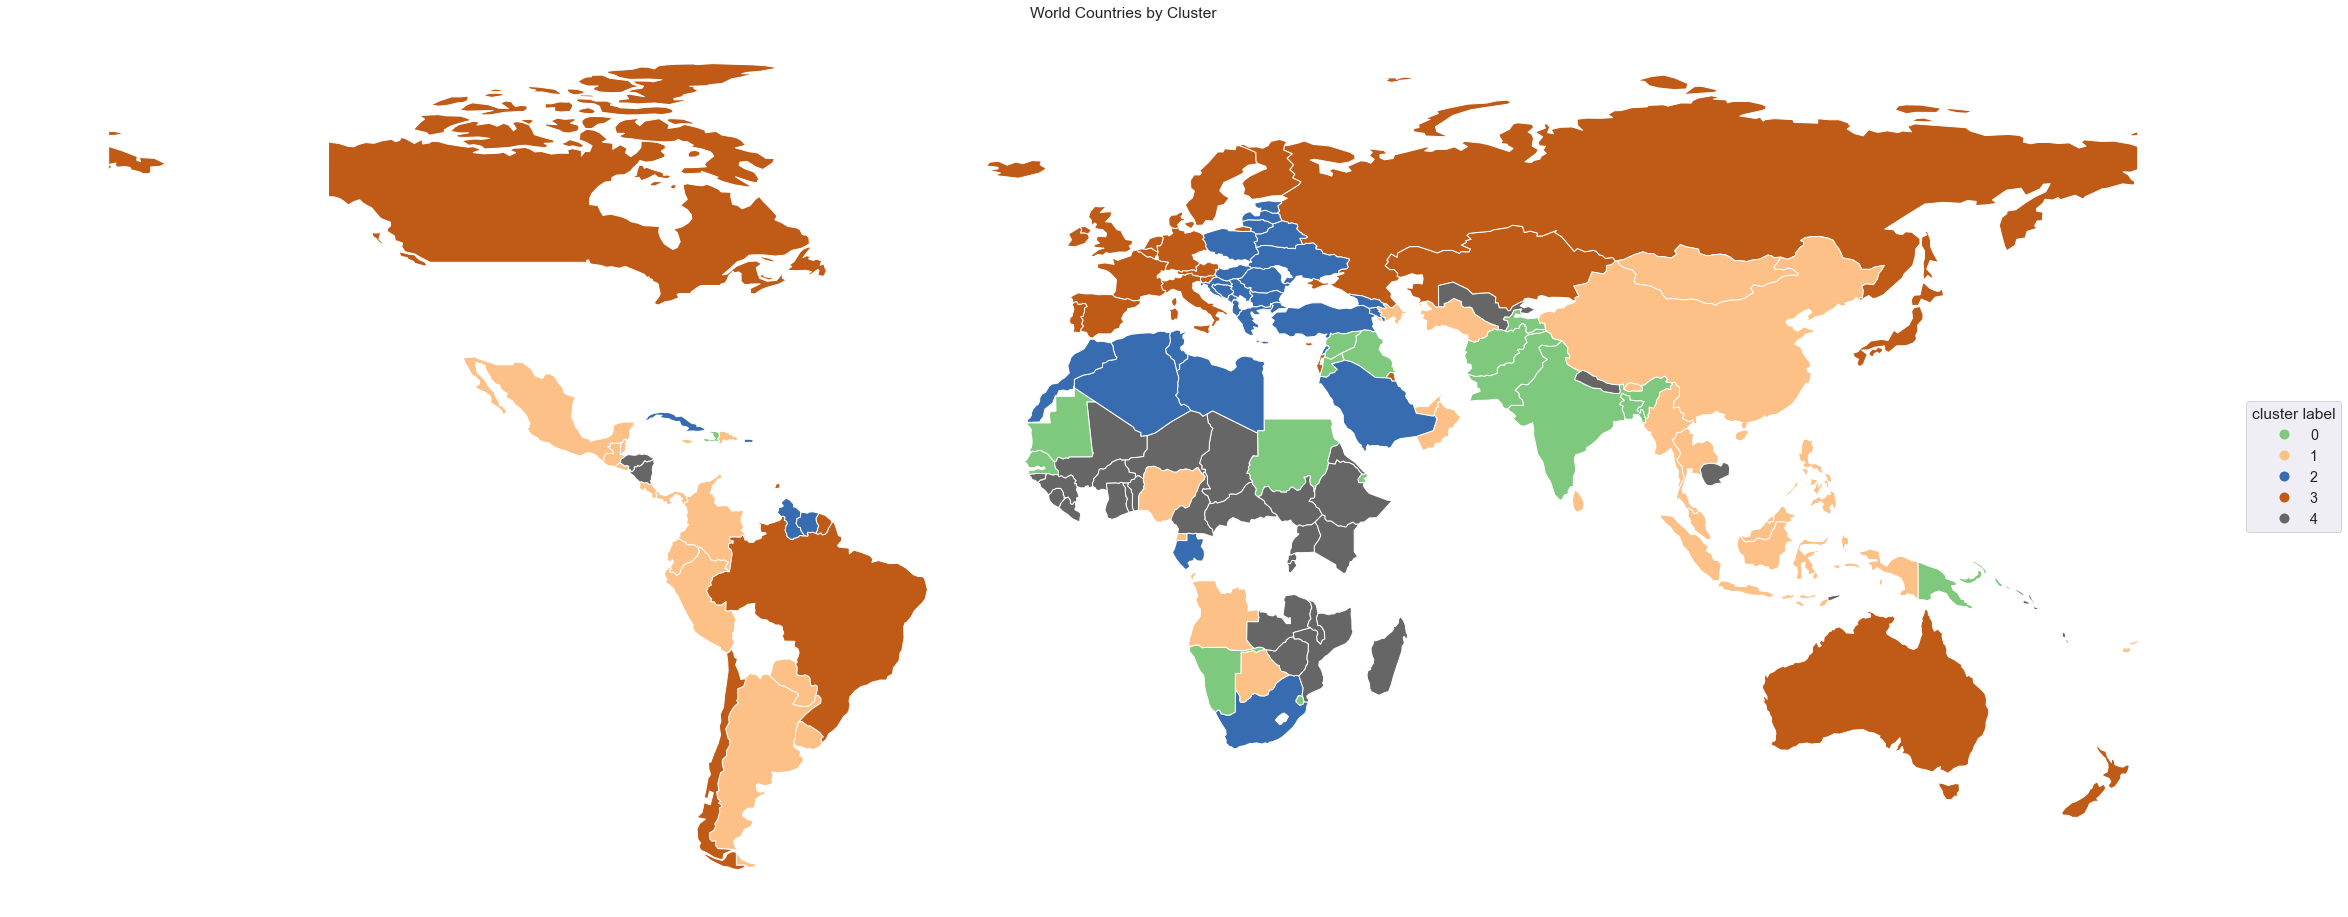

In [75]:
build_geo_df(world,df_cluster_11,df_pop,'2011')

<ipython-input-74-519c11658119>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'France'] = df['iso_a3'][df.name == 'France'].replace({'-99':'FRA'})
<ipython-input-74-519c11658119>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3'][df.name == 'Norway'] = df['iso_a3'][df.name == 'Norway'].replace({'-99':'NOR'})
<ipython-input-74-519c11658119>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['iso_a3

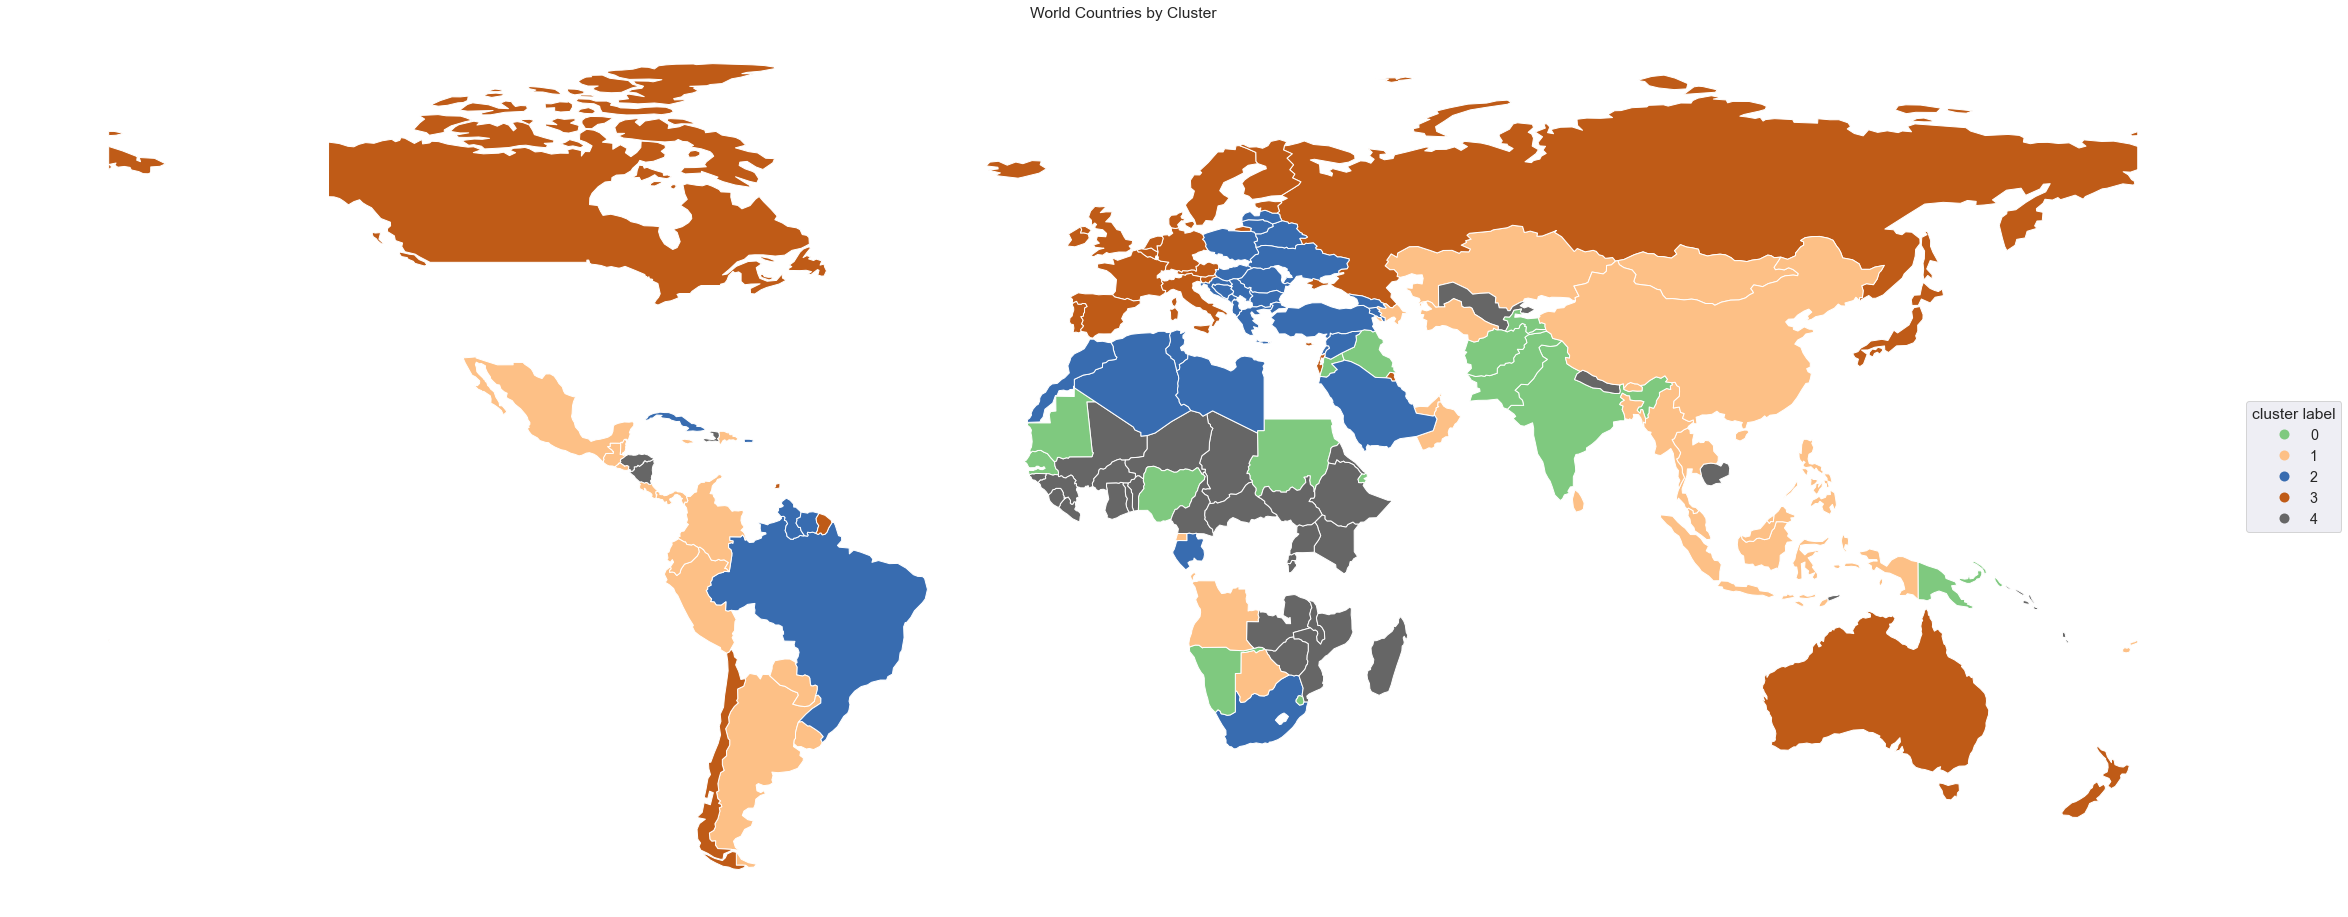

In [76]:
build_geo_df(world,df_cluster_2,df_pop,'2017')

In [77]:
df_cluster_2[df_cluster_2.labels != df_cluster_11.labels]

per_total_employment  all_disorders  Week_hours_PC  \
location_name                                                              
Bangladesh                       56.290001   14013.357122      46.932260   
Brazil                           55.840000   16418.249906      37.705381   
Estonia                          60.090000   17488.412709      38.791686   
Haiti                            58.410000   12052.838198      40.336927   
Kazakhstan                       65.849998   13623.137560      38.090799   
Nigeria                          49.599998   11145.825045      43.060356   
Syrian Arab Republic             40.500000   14198.014814      42.196742   

                            GDP_PC  labels  
location_name                               
Bangladesh             1563.913699       1  
Brazil                 9925.386238       2  
Estonia               20458.460729       3  
Haiti                  1294.239746       4  
Kazakhstan             9247.581331       1  
Nigeria                1968.564738       0  
Syrian Arab Republic   6982.389313       2